# Quantum Simulation on Noisy Superconducting Quantum Computers

## Introduction

This notebook is a companion to our paper \[1\] on quantum simulation. This notebook is not written as a research paper nor is it an introductory level tutorial; the context for some techniques will be missing as well as rigorous theoretical explanations. (These can be found in the paper \[1\] and subsequent citations.) Instead, this notebook aims to demonstrate minimal working examples of state-of-the-art techniques using Qiskit with the intent for you to build upon them. We demonstrate the time evolution of a simple tight binding model and various error mitigation techniques. Note that this tight-binding model can be solved exactly because it is a quadratic fermionic Hamiltonian, but we will be Trotterizing it for expository purposes. We hope you find the source code useful to jump start your own quantum research into more complicated models and methods.

We would love to see how you build on these ideas and methods for your own work!

[\[1\]](https://arxiv.org/abs/2209.02795) "Quantum Simulation on Noisy Quantum Computers", Kaelyn J. Ferris, A.J. Rasmusson, Nicholas T. Bronn, Olivia Lanes. [arXiv:2209.02795 \[quant-ph\]](https://arxiv.org/abs/2209.02795) (2022)

## The Tight Binding Model

The [tight-binding model](https://en.wikipedia.org/wiki/Tight_binding) is an exemplary model for physical systems with tightly bound particles. For example, physical systems where electrons are tightly bond to nuclei can be approximated by a tight binding model. It is also apart of other, more complicated, models, which we briefly discuss in the [paper](https://arxiv.org/abs/2209.02795). This makes it a nice minimal example, because it can be added upon in various ways to model many other types of systems.

In this specific example, we'll consider the case of a single particle that can "hop" between 5 lattice sites. There is a "hopping strength" $\tau$ to hop between different binding sites. We ignore any spin degree of freedom to the particle. We include a defect in the way of a hopping term that has a different value $\tau_d$. The particle will initially start on the left most site of the lattice. **Our goal is to measure the state dynamics of the particle.**

The tight binding model (ignoring spin and no defect) follows the Hamiltonian
$$
H = -\tau \sum_{\langle i, j\rangle}^{N} \left( c_{i}^{\dagger} c_{j} + c_{j}^{\dagger} c_{i} \right) \;.
$$

Let's consider a 1D chain of 5 sites. The Hamiltonian is then
$$
\begin{align}
H &= -\tau \sum_{i=0}^{3} \left( c_{i}^{\dagger} c_{i+1} + c_{i+1}^{\dagger} c_{i} \right) \;.
\end{align}
$$

Now, let's include the defect hopping term in the lattice, and set the values $\tau = 1$ and $\tau_d = 0.5$ with $\tau_d$ between sites 2 and 3.

$$
\begin{equation}
H = -\tau \sum_{i=(0,1,3)} \left( c_{i}^{\dagger} c_{i+1} + c_{i+1}^{\dagger} c_{i} \right) - \tau_d \left( c_{2}^{\dagger} c_{3} + c_{3}^{\dagger} c_{2} \right) \;.
\end{equation}
$$

See the [paper](https://arxiv.org/abs/2209.02795) for full details.

![img](figures/lattice.png)

### Transformation to Pauli Operators
We transform the fermionic Hamiltonian to a spin Hamiltonian, so it can be simulated on a quantum computer. (See the [paper](https://arxiv.org/abs/2209.02795) and literature references for more details.)

In mapping annihilation and creation operators to Pauli operators (labeled $X$, $Y$, $Z$, and the identity as $I$), we are mapping whether a site is occupied or not. Remember that we are ignoring any spin degree of freedom.

### Creation and Annihilation Operators
The action of the creation operator on the vacuum state "creates" or "raises" the state $c^{\dagger}|0\rangle = |1\rangle$. Action of the annihilation operator on the vacuum "annihilates" or "lowers" the state to zero $c|1\rangle = |0\rangle$. Following the Jordan-Wigner transformation (but making adjustments to ignore the spin of the particle), the creation $c^{\dagger}$ and annihilation $c$ operators map to Pauli raising $\sigma_+$ and lowering $\sigma_-$ operators.

$$
\begin{align}
c^{\dagger}_i &= \sigma_{+} = Z_0 \dots Z_{i-1} \left( \dfrac{X_i - i Y_i}{2} \right) I_{i+1} \dots I_N \\
c_i &= \sigma_{-} = Z_0 \dots Z_{i-1} \left( \dfrac{X_i + i Y_i}{2} \right) I_{i+1} \dots I_N
\end{align}
$$

Note that these definitions are typically switched when working in the spin-1/2 basis.

Applying the transformation, and including the defect between sites 2 and 3 (as described in the paper), the Hamiltonian becomes
$$
\begin{equation}
H = -\frac{\tau}{2} \sum_{i=(0,1,3)} \left( X_i X_{i+1} + Y_i Y_{i+1} \right) -\frac{\tau_d}{2} \left( X_2 X_{3} + Y_2 Y_{3} \right)
\end{equation}
$$

We're now ready to write this Hamiltonian in Qiskit.

In [1]:
import numpy as np

from scipy.optimize import curve_fit
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.dagcircuit import DAGCircuit, DAGNode, DAGOpNode

import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 16})  # enlarge matplotlib fonts

from tqdm import tqdm

from qiskit.opflow import Zero, One, I, X, Y, Z
from qiskit.circuit import Parameter

**Qiskit nature method.** If we want to start from fermionic operator form of the Hamiltonian $H = -\tau \sum_{i=(0,1,3)} \left( c_{i}^{\dagger} c_{i+1} + c_{i+1}^{\dagger} c_{i} \right) - \tau_d \left( c_{2}^{\dagger} c_{3} + c_{3}^{\dagger} c_{2} \right) \;,$ we can use functionality from [Qiskit nature](https://qiskit.org/documentation/nature/) to define the Hamiltonian in terms of fermionic second quantization operators and have qiskit do the Jordan-Wigner transformation to Pauli operators. This is shown below but not currently used in the notebook as FermionicOp does not currently support [Parameters](https://qiskit.org/documentation/stubs/qiskit.circuit.Parameter.html).

In [2]:
from qiskit_nature.operators.second_quantization import FermionicOp
from qiskit_nature.mappers.second_quantization import JordanWignerMapper

# TODO: update once FermionicOp supports Parameters. See Github Issue: https://github.com/Qiskit/qiskit-nature/issues/828
def compute_H_secondquant(tau, tau_d, num_sites, defect_locs):
    """
    Compute 1D spinless tight-binding Hamiltonian with "defective" interactions on specificed edges by first
        defining the system with a FermionicOp object followed by a JordanWigner transform.

    Args:
        tau - float; strength of hopping term between all sites except at the defect edge(s)
        tau_d - float; strength of hopping term at defect edge(s)
        num_sites - int; number of lattice sites in the 1D chain
        defect_locs - list or array of ints; index location(s) of defect edge(s). Indexed such that the left most edge is at position 0 and the rightmost is 4

    Returns:
        pauli_H - PauliSumOp; the Hamiltonian in Pauli operators
    """
    second_quant_H = 0
    for site in range(num_sites - 1):
        if site in defect_locs:
            second_quant_H += (
                FermionicOp("+_{}".format(site)) @ FermionicOp("-_{}".format(site + 1))
                + FermionicOp("+_{}".format(site + 1))
                @ FermionicOp("-_{}".format(site))
            ) * tau_d
        else:
            second_quant_H += (
                FermionicOp("+_{}".format(site)) @ FermionicOp("-_{}".format(site + 1))
                + FermionicOp("+_{}".format(site + 1))
                @ FermionicOp("-_{}".format(site))
            ) * tau
    # Transform to Pauli Operators
    jw_mapper = JordanWignerMapper
    pauli_H = JordanWignerMapper.map(jw_mapper, second_quant_H)

    return pauli_H


# Example computation
compute_H_secondquant(-1, -0.5, 5, [2])

PauliSumOp(SparsePauliOp(['IIIYY', 'IIIXX', 'IIYYI', 'IIXXI', 'IYYII', 'IXXII', 'YYIII', 'XXIII'],
              coeffs=[-0.5 +0.j, -0.5 +0.j, -0.5 +0.j, -0.5 +0.j, -0.25+0.j, -0.25+0.j,
 -0.5 +0.j, -0.5 +0.j]), coeff=1.0)

**Qiskit Opflow method.** If we want to start directly with the Pauli operator form of the Hamiltonian (doing the JW transform with "pen and paper") $H = -\frac{\tau}{2} \sum_{i=(0,1,3)} \left( X_i X_{i+1} + Y_i Y_{i+1} \right) -\frac{\tau_d}{2} \left( X_2 X_{3} + Y_2 Y_{3} \right) \;,$ then we directly use [Qiskit opflow](https://qiskit.org/documentation/apidoc/opflow.html)'s Pauli operators to string together the Hamiltonian terms. This is shown below and will be the method called later in the notebook as this method supports [Parameters](https://qiskit.org/documentation/stubs/qiskit.circuit.Parameter.html).

In [3]:
def compute_H(tau, tau_d, num_sites, defect_locs):
    """
    Compute 1D spinless tight-binding Hamiltonian with "defective" interactions on specificed edges

    Args:
        tau - float; strength of hopping term between all sites except at the defect edge(s)
        tau_d - float; strength of hopping term at defect edge(s)
        num_sites - int; number of lattice sites in the 1D chain
        defect_locs - list or array of ints; index location(s) of defect edge(s). Indexed such that the left most edge is at position 0 and the rightmost is 4

    Returns:
        H - SummedOp; the Hamiltonian
    """

    H = 0
    for i in range(num_sites - 1):
        if i in defect_locs:
            H += -tau_d / 2 * ((I ^ (num_sites - i - 2)) ^ (X ^ X) ^ (I ^ i))
            H += -tau_d / 2 * ((I ^ (num_sites - i - 2)) ^ (Y ^ Y) ^ (I ^ i))
        else:
            H += -tau / 2 * ((I ^ (num_sites - i - 2)) ^ (X ^ X) ^ (I ^ i))
            H += -tau / 2 * ((I ^ (num_sites - i - 2)) ^ (Y ^ Y) ^ (I ^ i))
    return H


# Example computation. This Hamiltonian is the same model we cover in the paper and will persist through the notebook.
num_sites = 5
defect_location = [2]

# Parameterized hopping strengths
tau = Parameter("τ")
tau_d = Parameter("τ_d")
H_param = compute_H(tau, tau_d, num_sites, defect_location)

# Select specific tau and tau_d values
H = H_param.bind_parameters({tau: 1, tau_d: 0.5})

# Print Hamiltonian operators to confirm it's what we expect
H

SummedOp([PauliOp(Pauli('IIIXX'), coeff=-0.5), PauliOp(Pauli('IIIYY'), coeff=-0.5), PauliOp(Pauli('IIXXI'), coeff=-0.5), PauliOp(Pauli('IIYYI'), coeff=-0.5), PauliOp(Pauli('IXXII'), coeff=-0.25), PauliOp(Pauli('IYYII'), coeff=-0.25), PauliOp(Pauli('XXIII'), coeff=-0.5), PauliOp(Pauli('YYIII'), coeff=-0.5)], coeff=1.0, abelian=False)

With the Hamiltonian, we can now construct its associated time evolution operator.

In [4]:
# Time evolution operator for a Hamiltonian H and time time_param
def compute_U(H, t):
    """
    Compute the time evolution operator.

    Args:
        H - OperatorBase (such as SummedOp); the Hamiltonan under which you wish to time evolve.

    Returns:
        U - EvolvedOp; The time evolution operator parameterized by variable 't'
    """
    U = (H * t).exp_i()
    return U


# Print example output
time_param = Parameter("t")
compute_U(H, time_param)

EvolvedOp(SummedOp([PauliOp(Pauli('IIIXX'), coeff=-0.5), PauliOp(Pauli('IIIYY'), coeff=-0.5), PauliOp(Pauli('IIXXI'), coeff=-0.5), PauliOp(Pauli('IIYYI'), coeff=-0.5), PauliOp(Pauli('IXXII'), coeff=-0.25), PauliOp(Pauli('IYYII'), coeff=-0.25), PauliOp(Pauli('XXIII'), coeff=-0.5), PauliOp(Pauli('YYIII'), coeff=-0.5)], coeff=1.0*t, abelian=False), coeff=1.0)

The observables we are interested in are the expectation values of the number operators $\langle n_i(t)\rangle$ at a given site $i$ after an evolution time $t$. In the case of a single particle, the number operator $\langle n_i(t)\rangle$ is the probability of the particle to occupy site $i$. Using the same JW transformation we used on the Hamiltonian, $\langle n_i(t)\rangle$ in terms of Pauli operators is

$$
\begin{equation}
n_i = c^{\dagger}_i c_i = \left(\dfrac{X_i - i Y_i}{2} \right) \left(\dfrac{X_i + i Y_i}{2}\right) = \left(\mathbb{1} - Z_i\right) / 2
\end{equation}
$$

We can construct these using Qiskit opflow as well.

In [5]:
# Define a list of number operators in terms of Pauli operators
n_is = [
    1 / 2 * ((I ^ num_sites) - ((I ^ i) ^ Z ^ (I ^ (num_sites - i - 1))))
    for i in range(num_sites)
]
n_is

[PauliSumOp(SparsePauliOp(['IIIII', 'ZIIII'],
               coeffs=[ 0.5+0.j, -0.5+0.j]), coeff=1.0),
 PauliSumOp(SparsePauliOp(['IIIII', 'IZIII'],
               coeffs=[ 0.5+0.j, -0.5+0.j]), coeff=1.0),
 PauliSumOp(SparsePauliOp(['IIIII', 'IIZII'],
               coeffs=[ 0.5+0.j, -0.5+0.j]), coeff=1.0),
 PauliSumOp(SparsePauliOp(['IIIII', 'IIIZI'],
               coeffs=[ 0.5+0.j, -0.5+0.j]), coeff=1.0),
 PauliSumOp(SparsePauliOp(['IIIII', 'IIIIZ'],
               coeffs=[ 0.5+0.j, -0.5+0.j]), coeff=1.0)]

### Classical Simulation
We can now classically simulate the state evolution and measure the observables of interest.

In [6]:
# Calculation of each number operator's expectation value over time

# Initial state on the far left of the 1D lattice
initial_state = One ^ Zero ^ Zero ^ Zero ^ Zero
# Define array of time points (technically these are relative to the hopping terms)
times = np.linspace(0, 4 * np.pi, 50)

# Calculation each number operator's expectation value at each time point
# Initialize a 2D array which we will fill with each site's expectation value (columns) and at each time point (rows)
evo_matrix = np.zeros((len(times), num_sites))
# Initialize 1D array to fill in variance of the sum of the number operators
var_matrix = np.zeros(len(times))

for i, time in enumerate(tqdm(times)):
    for j, ni in enumerate(n_is):
        # Compute the time evolution operator U(time) at time time
        U = compute_U(H, time_param).bind_parameters({time_param: time})
        # Compute the evolution of the initial state
        final_state = U @ initial_state
        # Compute the expectation value n_i
        evo_matrix[i, j] = np.abs((final_state.adjoint() @ ni @ final_state).eval())
    var_matrix[i] = (
        np.abs((final_state.adjoint() @ (sum(n_is) @ sum(n_is)) @ final_state).eval())
        - np.abs((final_state.adjoint() @ sum(n_is) @ final_state).eval()) ** 2
    )

  0%|          | 0/50 [00:00<?, ?it/s]

  4%|▍         | 2/50 [00:00<00:03, 12.57it/s]

  8%|▊         | 4/50 [00:00<00:03, 12.87it/s]

 12%|█▏        | 6/50 [00:00<00:03, 12.92it/s]

 16%|█▌        | 8/50 [00:00<00:03, 12.84it/s]

 20%|██        | 10/50 [00:00<00:03, 12.86it/s]

 24%|██▍       | 12/50 [00:00<00:02, 12.88it/s]

 28%|██▊       | 14/50 [00:01<00:02, 12.91it/s]

 32%|███▏      | 16/50 [00:01<00:02, 12.83it/s]

 36%|███▌      | 18/50 [00:01<00:02, 12.75it/s]

 40%|████      | 20/50 [00:01<00:02, 12.78it/s]

 44%|████▍     | 22/50 [00:01<00:02, 12.79it/s]

 48%|████▊     | 24/50 [00:01<00:02, 12.82it/s]

 52%|█████▏    | 26/50 [00:02<00:01, 12.82it/s]

 56%|█████▌    | 28/50 [00:02<00:01, 12.81it/s]

 60%|██████    | 30/50 [00:02<00:01, 12.84it/s]

 64%|██████▍   | 32/50 [00:02<00:01, 12.82it/s]

 68%|██████▊   | 34/50 [00:02<00:01, 12.77it/s]

 72%|███████▏  | 36/50 [00:02<00:01, 12.68it/s]

 76%|███████▌  | 38/50 [00:02<00:00, 12.70it/s]

 80%|████████  | 40/50 [00:03<00:00, 12.73it/s]

 84%|████████▍ | 42/50 [00:03<00:00, 12.71it/s]

 88%|████████▊ | 44/50 [00:03<00:00, 12.73it/s]

 92%|█████████▏| 46/50 [00:03<00:00, 12.57it/s]

 96%|█████████▌| 48/50 [00:03<00:00, 12.41it/s]

100%|██████████| 50/50 [00:03<00:00, 12.41it/s]

100%|██████████| 50/50 [00:03<00:00, 12.71it/s]

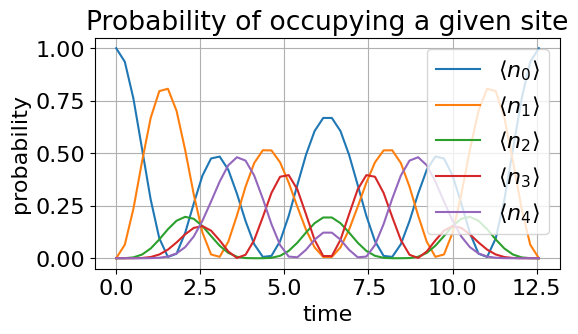

In [7]:
# Plot the time evolution
# list of labels for the plot
num_op_labels = [r"$\langle n_" + str(i) + "\\rangle$" for i in range(num_sites)]

plt.figure(figsize=(6, 3))
plt.plot(times, evo_matrix)
plt.xlabel("time")
plt.ylabel("probability")
plt.title("Probability of occupying a given site")
plt.grid()
plt.legend(num_op_labels)
plt.show()

Let's try another kind of plot to get a sense for how the particle moves across the lattice over time.

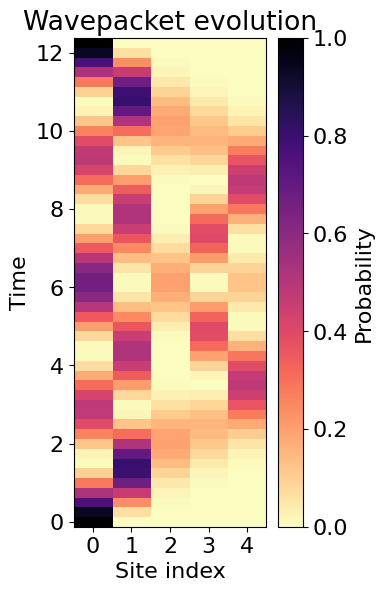

In [8]:
plt.figure(figsize=(4, 6))
plt.imshow(evo_matrix, origin="lower", aspect="auto", vmin=0, vmax=1, cmap="magma_r")
plt.xticks(np.arange(num_sites), labels=np.arange(num_sites))
plt.yticks(
    np.arange(0, evo_matrix.shape[0], 8), labels=np.arange(0, 4 * np.pi, 2).astype(int)
)
plt.ylabel("Time")
plt.xlabel("Site index")
cbar = plt.colorbar()
cbar.set_label("Probability")
plt.tight_layout()
plt.title("Wavepacket evolution")
plt.show()

#### Particle conservation check

It's always a good idea to test if a computer is giving something that makes sense. One such test, and a rather low effort one, is to compute the probability of finding the particle across all sites at each time point. Since we know there is only one particle to begin with and particle number is conserved, we should calculate 1 for all time steps. We will later use this fact in post-processing our quantum computer data by throwing out any measurements that don't preserve particle number.

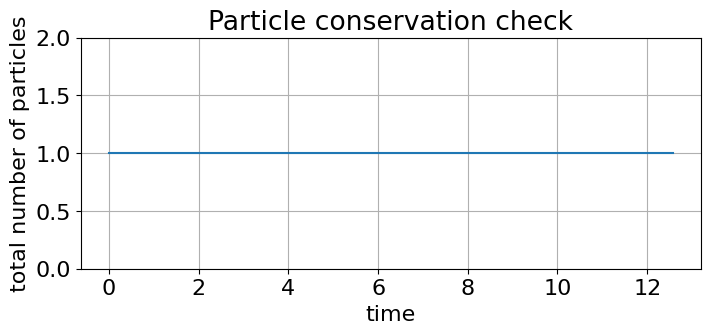

In [9]:
# Check that at each time point, the total number of particles is constant
plt.figure(figsize=(8, 3))
plt.plot(times, np.sum(evo_matrix, axis=1))
plt.xlabel("time")
plt.ylabel("total number of particles")
plt.title("Particle conservation check")
plt.ylim([0, 2])
plt.grid()
plt.show()

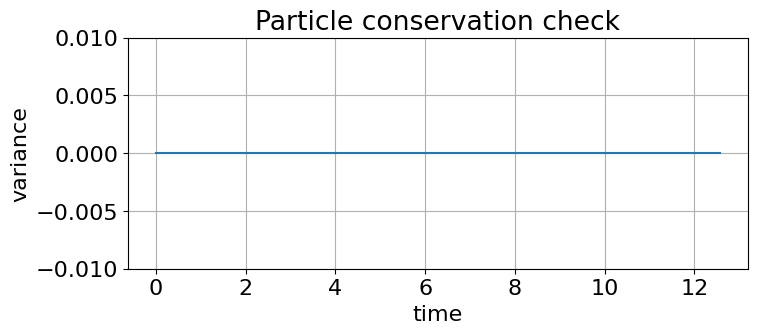

In [10]:
# Confirm the variance of the number of particles is zero to confirm particle number conservation.

plt.figure(figsize=(8, 3))
plt.plot(times, var_matrix)
plt.ylim([-0.01, 0.01])
plt.xlabel("time")
plt.ylabel("variance")
plt.title("Particle conservation check")
plt.grid()
plt.show()

### Trotterization
To simulate these state dynamics on a quantum computer, we've chosen to use the Trotter-Suzuki decomposition of the time evolution. Remember that this tight-binding model can be solved exactly because it is a quadratic fermionic Hamiltonian, but here, we will use it to illustrate the Trotter-Suzuki decomposition and subsequent techniques. This is covered more thoroughly in the [paper](https://arxiv.org/abs/2209.02795) and the references therein.

Trotterization of defect free Hamiltonian. (Defect version shown later on.)
$$
\begin{align}
H &= -\frac{t}{2} \sum_{i=0}^{3} \left( X_i X_{i+1} + Y_i Y_{i+1} \right) \\
H &= -\frac{t}{2}\left(X_0 X_1 + Y_0 Y_1 + X_1 X_2 + Y_1 Y_2 + X_2 X_3 + Y_2 Y_3 + X_3 X_4 + Y_3 Y_4 \right) \\
\end{align}
$$

The time evolution is then

$$
\begin{align}
U(\tau) &= \exp \left[i\frac{\tau t}{2}\left(X_0 X_1 + Y_0 Y_1 + X_1 X_2 + Y_1 Y_2 + X_2 X_3 + Y_2 Y_3 + X_3 X_4 + Y_3 Y_4 \right) \right] \\
U(\tau) &\approx \prod_{n=0}^N \exp \left[i\frac{\tau t}{2n}\left(X_0 X_1 + Y_0 Y_1\right)\right]^n \exp \left[i\frac{\tau t}{2n}\left(X_1 X_2 + Y_1 Y_2 \right) \right]^n \exp \left[i\frac{\tau t}{2n}\left(X_2 X_3 + Y_2 Y_3 \right) \right]^n \exp \left[i\frac{\tau t}{2n}\left(X_3 X_4 + Y_3 Y_4 \right) \right]^n \\
\end{align}
$$

Including defect

$$
\begin{equation}
U(\tau, \tau_d) \approx \prod_{n=0}^N \exp \left[i\frac{\tau t}{2n}\left(X_0 X_1 + Y_0 Y_1\right)\right]^n \exp \left[i\frac{\tau t}{2n}\left(X_1 X_2 + Y_1 Y_2 \right) \right]^n \exp \left[i\frac{\tau_d t}{2n}\left(X_2 X_3 + Y_2 Y_3 \right) \right]^n \exp \left[i\frac{\tau t}{2n}\left(X_3 X_4 + Y_3 Y_4 \right) \right]^n
\end{equation}
$$

Each pair of $XX$ and $YY$ interactions summed in the exponents do commute, so there could be further decomposition without need of trotterization. There is in fact efficient decompositions for such interactions (see the [qiskit circuit library](https://qiskit.org/documentation/apidoc/circuit_library.html)), but we will not go that here. It also depends on the type of gates we can/want to apply at the hardware level. We'll eventually work toward $R_{ZX}(\theta)$ gates, so let's stay in terms of separating $XX$ and $YY$.

$$
\begin{align}
U(\tau) &\approx \prod_{n=0}^N \exp \left[i\frac{\tau t}{2n}\left(X_0 X_1\right)\right]^n \exp \left[i\frac{\tau t}{2n}\left(Y_0 Y_1\right)\right]^n \exp \left[i\frac{\tau t}{2n}\left(X_1 X_2\right)\right]^n \exp \left[i\frac{\tau t}{2n}\left(Y_1 Y_2 \right) \right]^n \exp \left[i\frac{\tau t}{2n}\left(X_2 X_3\right)\right]^n \exp \left[i\frac{\tau t}{2n}\left(Y_2 Y_3 \right) \right]^n \exp \left[i\frac{\tau t}{2n}\left(X_3 X_4\right)\right]^n \exp \left[i\frac{\tau t}{2n}\left(Y_3 Y_4 \right) \right]^n \\
\end{align}
$$

Including defect is a simple parameter change at the correct operator
$$
\begin{align}
U(\tau) &\approx \prod_{n=0}^N \exp \left[i\frac{\tau t}{2n}\left(X_0 X_1\right)\right]^n \exp \left[i\frac{\tau t}{2n}\left(Y_0 Y_1\right)\right]^n \exp \left[i\frac{\tau t}{2n}\left(X_1 X_2\right)\right]^n \exp \left[i\frac{\tau t}{2n}\left(Y_1 Y_2 \right) \right]^n \exp \left[i\frac{\tau_d t}{2n}\left(X_2 X_3\right)\right]^n \exp \left[i\frac{\tau_d t}{2n}\left(Y_2 Y_3 \right) \right]^n \exp \left[i\frac{\tau t}{2n}\left(X_3 X_4\right)\right]^n \exp \left[i\frac{\tau t}{2n}\left(Y_3 Y_4 \right) \right]^n \\
\end{align}
$$


In [11]:
from qiskit.opflow import Suzuki


def compute_U_trot(H, time, trotter_steps, order=1):
    """
    Apply the Suzuki-Trotter approximation to the Hamiltonian H to compute a trotterized unitary time evolution operator.

    Args:
        H - OperatorBase (such as SummedOp); Hamiltonian governing time dynamics.
        time - float or Parameter; time of evolution under Hamtilonian H.
        tortter_steps - int; number of trotter_steps.
        order - int; order of Suzuki-Trotterization approximation to use when approximating H.

    Returns:
        U_trot - ComposeOp; The Trotterized time evolution operator
    """

    U_trot = Suzuki(trotter_steps, order=order).convert(time * H)
    return U_trot


# Print example output
compute_U_trot(H, 1, 2)

ComposedOp([EvolvedOp(PauliOp(Pauli('IIIXX'), coeff=-0.25), coeff=1.0), EvolvedOp(PauliOp(Pauli('IIIYY'), coeff=-0.25), coeff=1.0), EvolvedOp(PauliOp(Pauli('IIXXI'), coeff=-0.25), coeff=1.0), EvolvedOp(PauliOp(Pauli('IIYYI'), coeff=-0.25), coeff=1.0), EvolvedOp(PauliOp(Pauli('IXXII'), coeff=-0.125), coeff=1.0), EvolvedOp(PauliOp(Pauli('IYYII'), coeff=-0.125), coeff=1.0), EvolvedOp(PauliOp(Pauli('XXIII'), coeff=-0.25), coeff=1.0), EvolvedOp(PauliOp(Pauli('YYIII'), coeff=-0.25), coeff=1.0), EvolvedOp(PauliOp(Pauli('IIIXX'), coeff=-0.25), coeff=1.0), EvolvedOp(PauliOp(Pauli('IIIYY'), coeff=-0.25), coeff=1.0), EvolvedOp(PauliOp(Pauli('IIXXI'), coeff=-0.25), coeff=1.0), EvolvedOp(PauliOp(Pauli('IIYYI'), coeff=-0.25), coeff=1.0), EvolvedOp(PauliOp(Pauli('IXXII'), coeff=-0.125), coeff=1.0), EvolvedOp(PauliOp(Pauli('IYYII'), coeff=-0.125), coeff=1.0), EvolvedOp(PauliOp(Pauli('XXIII'), coeff=-0.25), coeff=1.0), EvolvedOp(PauliOp(Pauli('YYIII'), coeff=-0.25), coeff=1.0)], coeff=1.0, abelian=Fals

In [12]:
# Time evolution calculation using same parameters as the exact classical calculation

# Initial state on the far left (same as before)
initial_state = One ^ Zero ^ Zero ^ Zero ^ Zero

# Number of trotter steps
trotter_steps = 8

# Calculate each number operator's expectation value at each time point and store in a 2D array
evo_matrix_trot = np.zeros((len(times), num_sites))
for i, ni in enumerate(tqdm(n_is)):
    for j, time in enumerate(times):
        U = compute_U_trot(H, time, trotter_steps)
        final_state = U @ initial_state
        evo_matrix_trot[j, i] = np.abs(
            (final_state.adjoint() @ ni @ final_state).eval()
        )

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:03<00:12,  3.21s/it]

 40%|████      | 2/5 [00:06<00:09,  3.21s/it]

 60%|██████    | 3/5 [00:09<00:06,  3.20s/it]

 80%|████████  | 4/5 [00:12<00:03,  3.23s/it]

100%|██████████| 5/5 [00:16<00:00,  3.22s/it]

100%|██████████| 5/5 [00:16<00:00,  3.22s/it]

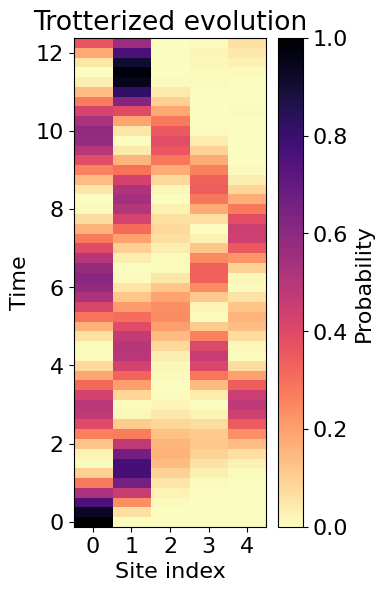

In [13]:
plt.figure(figsize=(4, 6))
plt.imshow(
    evo_matrix_trot, origin="lower", aspect="auto", vmin=0, vmax=1, cmap="magma_r"
)
plt.xticks(np.arange(num_sites), labels=np.arange(num_sites))
plt.yticks(
    np.arange(0, evo_matrix.shape[0], 8), labels=np.arange(0, 4 * np.pi, 2).astype(int)
)
plt.ylabel("Time")
plt.xlabel("Site index")
cbar = plt.colorbar()
cbar.set_label("Probability")
plt.tight_layout()
plt.title("Trotterized evolution")
plt.show()

The evolution above looks quite similar the exact evolution, but not quite. This is due to trotter error.

### Trotter Error
The Suzuki-Trotter approximation is just that: an approximation. To illustrate how this might affect estimating the exact dynamics, let's plot the evolution of the exact solution with various trotter steps.

In [14]:
# Number of trotter steps
trotter_steps = 5
# Calculate each number operator's expectation value at each time point
evo_matrix_trot_5 = np.zeros((len(times), num_sites))
for i, ni in enumerate(tqdm(n_is)):
    for j, time in enumerate(times):
        U = compute_U_trot(H, time, trotter_steps)
        final_state = U @ initial_state
        evo_matrix_trot_5[j, i] = np.abs(
            (final_state.adjoint() @ ni @ final_state).eval()
        )

# Number of trotter steps
trotter_steps = 8
# Calculate each number operator's expectation value at each time point
evo_matrix_trot_8 = np.zeros((len(times), num_sites))
for i, ni in enumerate(tqdm(n_is)):
    for j, time in enumerate(times):
        U = compute_U_trot(H, time, trotter_steps)
        final_state = U @ initial_state
        evo_matrix_trot_8[j, i] = np.abs(
            (final_state.adjoint() @ ni @ final_state).eval()
        )

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:02<00:08,  2.05s/it]

 40%|████      | 2/5 [00:04<00:06,  2.05s/it]

 60%|██████    | 3/5 [00:06<00:04,  2.03s/it]

 80%|████████  | 4/5 [00:08<00:02,  2.05s/it]

100%|██████████| 5/5 [00:10<00:00,  2.04s/it]

100%|██████████| 5/5 [00:10<00:00,  2.04s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:03<00:12,  3.23s/it]

 40%|████      | 2/5 [00:06<00:09,  3.23s/it]

 60%|██████    | 3/5 [00:09<00:06,  3.22s/it]

 80%|████████  | 4/5 [00:12<00:03,  3.18s/it]

100%|██████████| 5/5 [00:15<00:00,  3.16s/it]

100%|██████████| 5/5 [00:15<00:00,  3.18s/it]

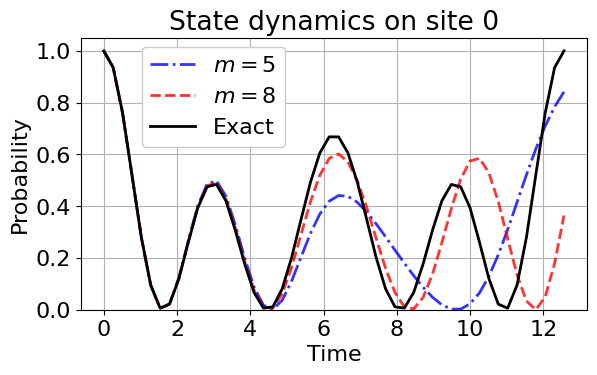

In [15]:
# Plot state dynamics over one particular site
site = 0

plt.figure(figsize=(6.25, 3.75))
plt.plot(
    times,
    evo_matrix_trot_5[:, site],
    "b-.",
    linewidth=2,
    label=r"$m=5$",
    markerfacecolor="royalblue",
    alpha=0.8,
)
plt.plot(
    times,
    evo_matrix_trot_8[:, site],
    "r--",
    linewidth=2,
    label="$m=8$",
    markerfacecolor="salmon",
    alpha=0.8,
)
plt.plot(
    times, evo_matrix[:, site], "k-", linewidth=2, label="Exact", markerfacecolor="grey"
)
plt.xlabel("Time")
plt.ylabel("Probability")
plt.ylim([0.0, 1.05])
plt.grid()
plt.legend(loc=(0.12, 0.6), framealpha=1)
plt.tight_layout()
plt.title("State dynamics on site " + str(site))
plt.show()

## Noisy Quantum Computer Implementation

We know what to expect from the quantum computer, so we're ready for a first-pass implementation! Let's get started with the usual Qiskit imports, provider access, backends, and backend properties.

### Import Qiskit, IBM credentials, and helper functions

In [16]:
from qiskit.opflow import PauliTrotterEvolution

# Define some useful function used later on in this section


def convert_U_trot_to_qc(U_trot):
    """
    Convert the U_trot ComposedOp object returned by compute_U_trot() to a bare quantum circuit.

    Tutorial on using PauliTrotterEvolution at
    https://qiskit.org/documentation/tutorials/operators/01_operator_flow.html#Part-IV:-Converters

    Args:
        U_trot - OperatorBase (such as ComposedOp); Trotterized unitary time evolution operator to be written in terms of a quantum circuit.

    Returns:
        qc_trot - QuantumCircuit; The trotterized quantum circuit associated with U_trot. The gates are decomposed down to single and two-qubit gates.
    """

    qc_trot = PauliTrotterEvolution().convert(U_trot)
    return (
        qc_trot.to_circuit().decompose().decompose()
    )  # add decompose methods so gates are not abstracted unitary blocks


def gen_trott_qc(H, time_param, trotter_steps, q_regs=[0, 1, 3, 5, 6]):
    """
    Generate the full trotter circuit for H with time as an unevaluated Parmaeter.

    Args:
        H - ; the Hamiltonain governed the Trotterized time evolution.
        time_param - ; paramterized time of the evolution. To be evaluated later.
        trotter_steps - int; number of Trotter steps
        q_regs - list of ints; the specific qubits of ibm_lagos to be used

    Returns:
        qc - QuantumCircuit; trotterized time evolution circuit including measurement gates and set over qubit layout
    """

    # Initialize quantum circuit
    # working with lagos so we have 7 qubits
    qrs = QuantumRegister(7)
    # but H only acts no 5 of the 7 qubits in the end, so we only measure 5 qubits in the end
    crs = ClassicalRegister(5)
    qc = QuantumCircuit(qrs, crs)

    # Prepare initial state |10000> (far left site)
    qc.x(q_regs[-1])

    # Compute unitary time operator
    U_trot_params = compute_U_trot(H, time_param, int(trotter_steps))
    # Convert to trotterized unitary to circuit
    qc_trot = convert_U_trot_to_qc(U_trot_params)
    # Append trotterized circuit to our circuit as a custom gate
    qc.append(qc_trot, q_regs)
    # Add measurements
    # mapping from quantum registers to classical registers depends on which 5 qubits were selected
    qc.measure(q_regs, crs)

    return qc.decompose()


def execute_qcs(qcs, backend, shots=10000, verbose=True):
    """
    Execute quantum circuits on a bakcend and monitor job. The job id will be displayed

    Args:
        qcs - QuantumCircuit or list of QuantumCircuits; These are the quantum circuit/circuits you wish to execute
        backend - IBMQBackend; the backend that will execute the circuits
        shots - int; number of repeated measurements
        verbose - bool; set to true if you want the job id printed

    Returns:
        job - IBMQJob; the job associated with the execution of quantum circuits qcs
    """

    # Execute QuantumCircuits qcs
    job = backend.run(qcs, shots=shots)
    if verbose:
        print("Job ID", job.job_id())

    # Run job monitor to see progress of job
    job_monitor(job)
    try:
        if job.error_message() is not None:
            print(job.error_message())
    except:
        pass

    return job


def dict_to_num_op_ex_val(counts, enforce_pc=True, verbose=False):
    """
    Convert counts (or QuasiDistribution) to the expectation value of the number operator at each site.

    This function can ignore shots that come from states that are not 10000, 01000, 00100, 00010, or 00001 (set enforce_pc=True).
    All other states would mean more (or less) particles were added (removed) to the system, which violates
    the particle conservation of the Hamiltonian. Expectation values are renormalized according to which
    shots obey particle conservation.

    Args:
        counts - dict {str: int/float}; dictation of keys with state label bitstrings (e.g. '00001') with the number of measured instances (int) or probability (float)
        enforce_pc - bool; if True, only shots from states that preserve single particle conservation (10000, 01000, 00100, 00010, or 00001) will be included in compuation
        verbose - bool; if True, print out the number of shots included in the computation.

    Returns:
        occuptation - 1D array; array of the expectation value of each number operators
        norm - int/float; number of measurements used in computing the expectation values/probability distribution norm
    """
    # Initialize expectation value of the z operator at each site
    z_exp_vals = np.zeros(num_sites)
    # Initialize expectation value of the number operator at each site (i.e. probability of occupying a given site)
    occupation = np.zeros(num_sites)
    norm = 0  # total number of measurements
    if enforce_pc:
        # Loop through the different measured states for a given time point
        for state_label, count_val in counts.items():
            # Loop through the individual bits of the state and compute the expectation value of Z at each bit (aka each site)
            # Only consider state_labels that have a single 1 in the bit-string (i.e. enforce conservation of particle number)
            number_of_1s = sum([int(s) for s in state_label])
            if number_of_1s == 1:
                # track the total number of shots/probability norm used in computing the expectation value
                norm += count_val
                for j, q_j in enumerate(state_label):
                    if q_j == "1":
                        z_exp_vals[j] -= count_val
                    else:
                        z_exp_vals[j] += count_val
        z_exp_vals /= norm
    else:
        for state_label, count_val in counts.items():
            # Loop through the individual bits of the state and compute the expectation value of Z at each site
            norm += count_val
            for j, q_j in enumerate(state_label):
                if q_j == "1":
                    z_exp_vals[j] -= count_val
                else:
                    z_exp_vals[j] += count_val
        z_exp_vals /= norm

    # Compute the expectation value of the number operators
    occupation = 1 / 2 * (1 - z_exp_vals)

    if verbose:
        return occupation, norm
    else:
        return occupation

In [17]:
# Importing standard Qiskit modules
from qiskit import (
    IBMQ,
    QuantumCircuit,
    QuantumRegister,
    ClassicalRegister,
    execute,
    transpile,
    schedule,
)
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter

from qiskit.providers.fake_provider import FakeLagos
from qiskit import schedule

# suppress warnings
import warnings

warnings.filterwarnings("ignore")

### Access backends and their info
We will work with the ibm_lagos device. To estimate circuit performance and other information, lagos's properties, configuration, defaults, and native gate set can be accessed. In the paper, we accessed the real backend. For ease of access, we'll implement everything with a simulator that emulates ibm_lagos's noise profile.

In [18]:
# load IBMQ Account data

# IBMQ.save_account(TOKEN, overwrite=True)  # replace TOKEN with your API token string (https://quantum-computing.ibm.com/lab/docs/iql/manage/account/ibmq)
# provider = IBMQ.load_account()

# Get backend for experiment
# Fill in the hub-group-project for your account
# provider = IBMQ.get_provider(hub="your-hub", group="your-group", project="your-project")

# Real backend
# backend = provider.get_backend("ibm_lagos")

# Simulated backend based on ibmq_lagos's device noise profile
# Use the line below for the latest error model. See: https://qiskit.org/documentation/apidoc/providers_fake_provider.html
# sim_noisy_lagos = QasmSimulator.from_backend(provider.get_backend('ibm_lagos'))
# A providerless noisy simulator, but may have an out-of-date noise model
backend = FakeLagos()

# Noiseless simulated backend for debugging
# backend = QasmSimulator()

In [19]:
# Get useful information about backend (used later on)
properties = backend.properties()
config = backend.configuration()
defaults = backend.defaults()

# Get native basis gates for backend
basis_gates = config.basis_gates

# Compute average SX gate error for backend
avg_sx_err = np.mean([properties.gate_error("sx", i) for i in range(7)])
# Compute average X gate error for backend
avg_x_err = np.mean([properties.gate_error("x", i) for i in range(7)])
# Compute the average CNOT gate error for backend
avg_cx_err = np.mean(
    [properties.gate_error("cx", (cm[0], cm[1])) for cm in config.coupling_map]
)

# Display gate error averages
print(f"Average CX gate error: {avg_cx_err:.5f}")
print(f"Average single qubit SX gate error: {avg_sx_err:.5f}")
print(f"Average single qubit X gate error: {avg_x_err:.5f}")

Average CX gate error: 0.00772
Average single qubit SX gate error: 0.00026
Average single qubit X gate error: 0.00026


### Generate quantum circuits for trotterized quantum simulation
Qiskit has functionality to directly [convert opflow objects into quantum circuits](https://qiskit.org/documentation/tutorials/operators/01_operator_flow.html#Part-IV:-Converters). This means we can use the U_trot method we made earlier to compute the unitary time evolution operator and then have it directly converted to a quantum circuit. Below, we'll use those functions defined earlier in the section.

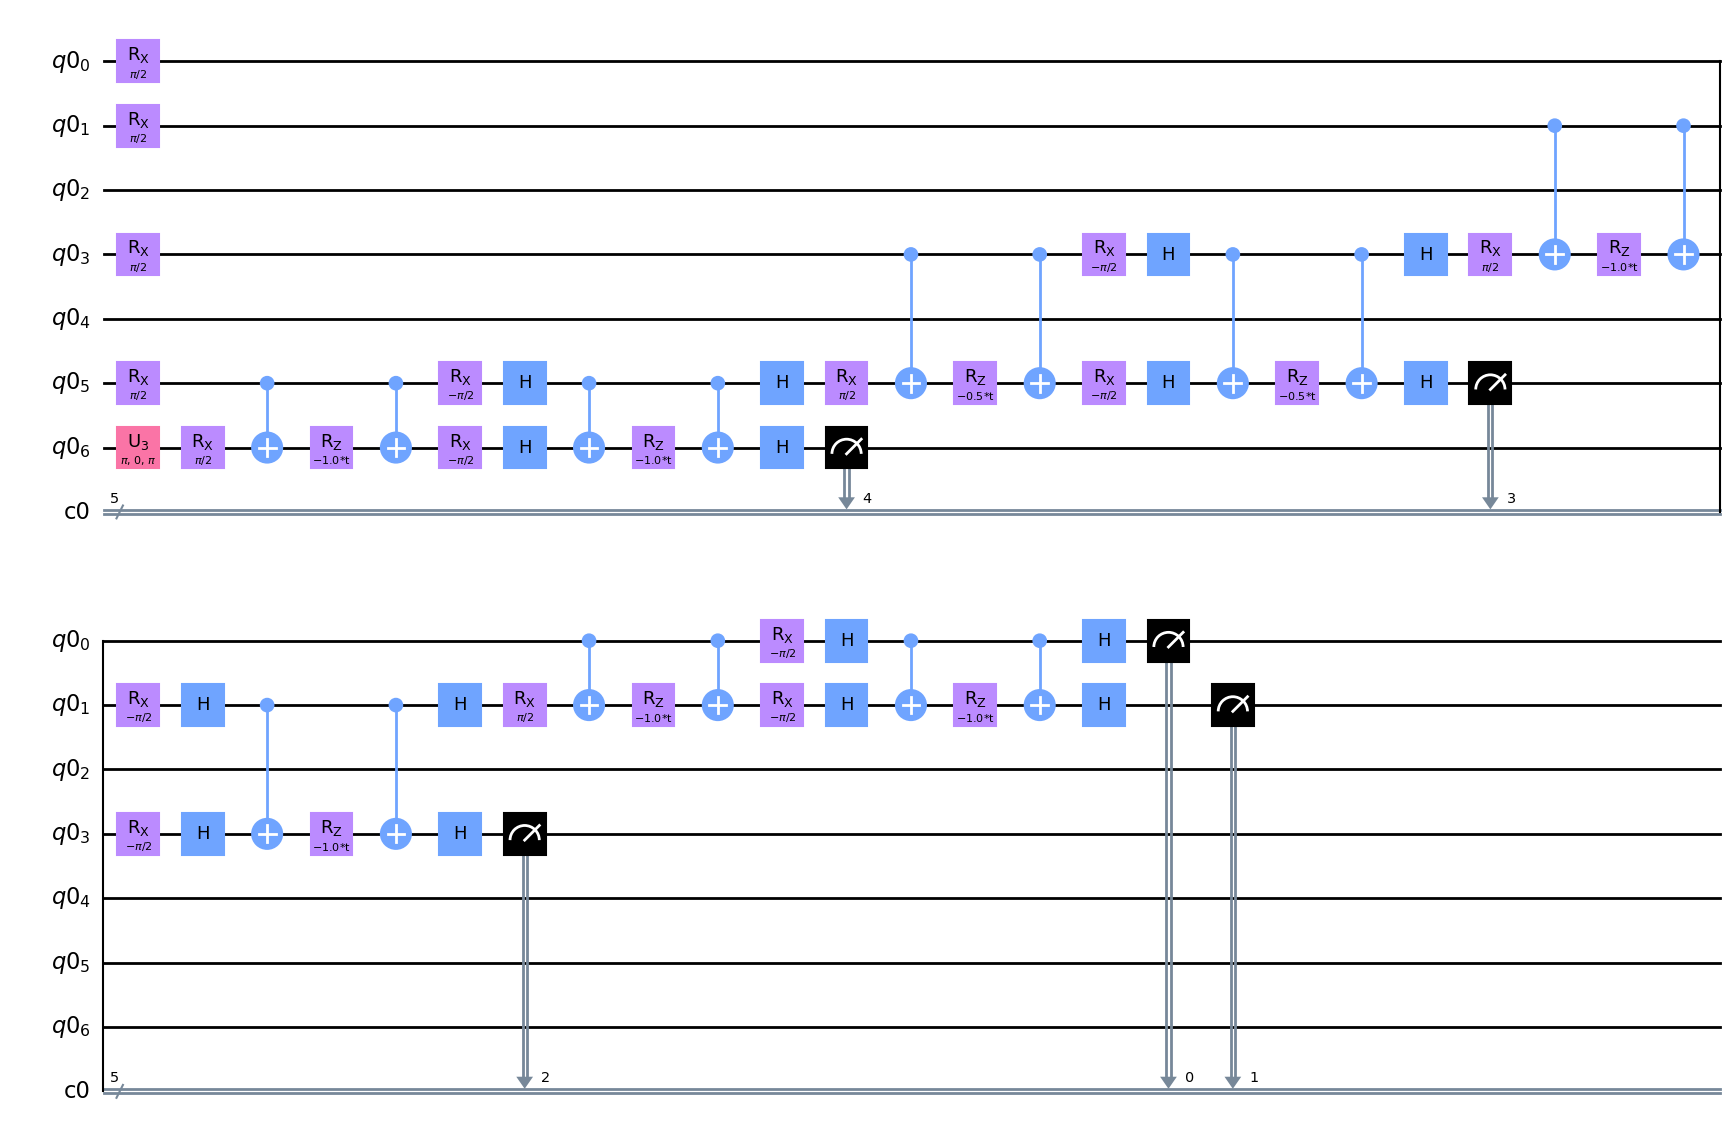

In [20]:
# Number of trotter steps
trotter_steps = 1

# Generate the trotterized quantum circuit
qc = gen_trott_qc(H, time_param, trotter_steps)
qc.draw("mpl")

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:00<00:00, 1362.50it/s]

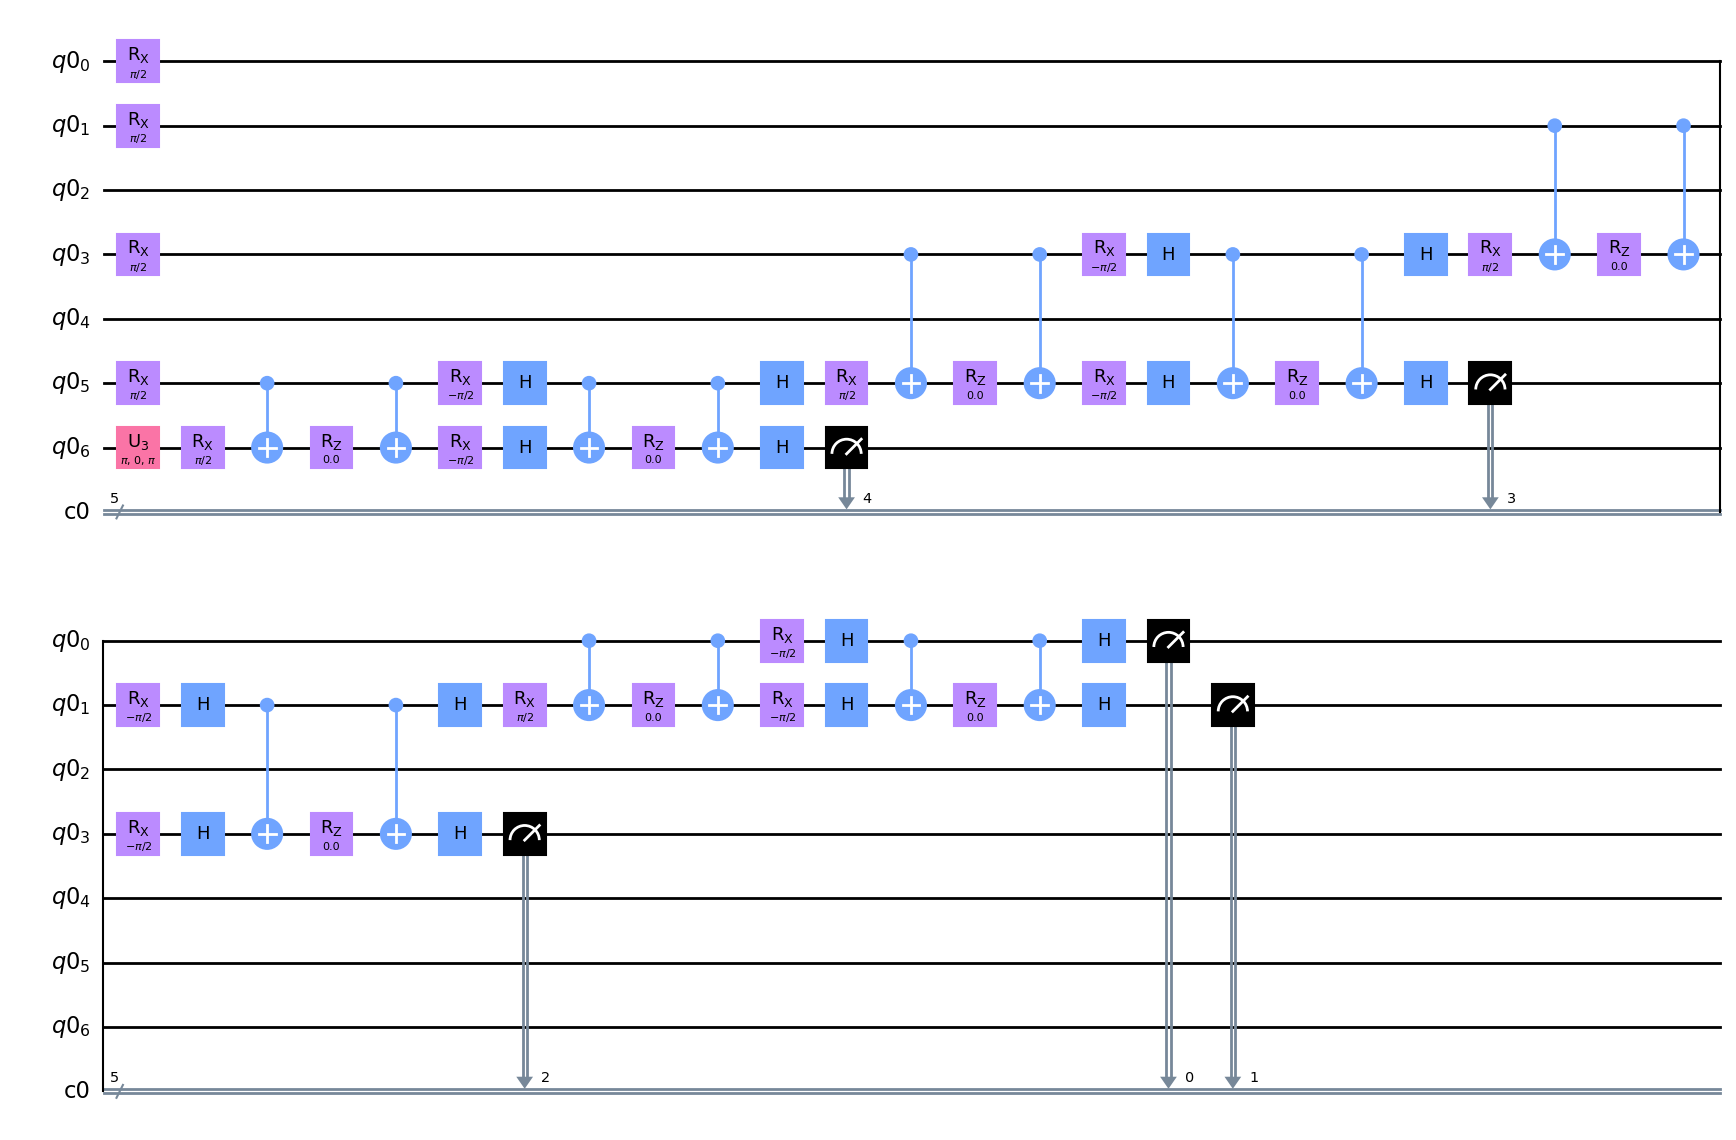

In [21]:
# Evaluate parameterized circuit over the range of time values used in the previous cells
qcs = []
# Bind parameters for each step in time series
for time in tqdm(times):
    qcs.append(qc.bind_parameters({time_param: time}))

qcs[0].draw("mpl")

### Quantify improvement from transpiler passes
Using the transpiler, we can reduce the total number of gates and duration of the circuit. This in turn reduces the total error in the quantum computation. Here we only show using the `optimization_level` argument. In later sections, we will demonstrate the exact transpiler passes that reduce the circuits. See the [paper](https://arxiv.org/abs/2209.02795) for details on the heuristic we use to estimate circuit fidelity.

In [22]:
# Check number of gate counts at the second to last time step

# Although we are transpiling here, the optimization_level=0 means it is only changing gates to be in the native gate set of ibm_lagos
qc_ops = transpile(qcs[-2], basis_gates=basis_gates, optimization_level=0).count_ops()
print("Circuit gate counts:", qc_ops)
# Check circuit reduction from transpiler at its highest optimization_level allows for heavy modifcation and reduction of the circuit
qc_t_ops = transpile(qcs[-2], basis_gates=basis_gates, optimization_level=3).count_ops()
print("Transpiled circuit gate counts:", qc_t_ops)

# Display various fidelity values between two circuits
print("\n--- Circuit gate error estimate ---")
cx_fid = (1 - avg_cx_err) ** qc_ops["cx"]
sx_fid = (1 - avg_sx_err) ** qc_ops["sx"]
total_fid = cx_fid * sx_fid
print(f"CX gate error contribution: {1 - cx_fid:.4f}")
print(f"SX gate error contribution: {1 - sx_fid:.4f}")
print(f"Total circuit fidelity: {total_fid:.4f}")

print("\n--- Transpiled circuit gate error estimate ---")
cx_t_fid = (1 - avg_cx_err) ** qc_t_ops["cx"]
sx_t_fid = (1 - avg_sx_err) ** qc_t_ops["sx"]
total_t_fid = cx_t_fid * sx_t_fid
print(f"CX gate error contribution: {1 - cx_t_fid:.4f}")
print(f"SX gate error contribution: {1 - sx_t_fid:.4f}")
print(f"Total circuit fidelity: {total_t_fid:.4f}")

Circuit gate counts: OrderedDict([('rz', 91), ('sx', 50), ('cx', 16), ('measure', 5)])
Transpiled circuit gate counts: OrderedDict([('rz', 29), ('sx', 20), ('cx', 8), ('measure', 5), ('x', 2)])

--- Circuit gate error estimate ---
CX gate error contribution: 0.1166
SX gate error contribution: 0.0128
Total circuit fidelity: 0.8721

--- Transpiled circuit gate error estimate ---
CX gate error contribution: 0.0601
SX gate error contribution: 0.0051
Total circuit fidelity: 0.9350


### Estimate circuit error and circuit duration vs number of trotter steps (transpiler optimization)
Let's expand the circuit fidelity analysis we did in the above section to a range of trotter steps.

In [23]:
def compute_circuit_gate_fidelity(
    num_two_q_gates, num_single_q_gates, ave_two_q_gate_fid, ave_single_q_fid
):
    """
    Estimate the fidelity of the combined two-qubit and single-qubit gates in a circuit.

    Args:
        num_two_q_gates - int; the number of two-qubit gates. Assumes the same two-qubit gate is used throughout the circuit.
        num_single_q_gates - int; the number of single-qubit gates. Assumes the same single-qubit gate is used throughout the circuit
        ave_two_q_gate_fid - float; the average fidelity of the two-qubit gate
        ave_single_q_fit - float; the average fidelity of the single-qubit gate

    Returns:
        fidelity - float; estimated fidelity of circuit operations (see paper for details)
    """

    return (ave_two_q_gate_fid**num_two_q_gates) * (
        ave_single_q_fid**num_single_q_gates
    )

In [24]:
# Evaulate all circuits at the final time evolution time
t_final = times[-2]

# Number of trotter steps
trotter_steps_array = np.arange(1, 13)

# Empty list to store untranspiled ("digital") circuits
qcs_digital = []
# Empty list to store heavily transpiled circuits
qcs_transpiled = []
# Empty list to store estimate of quantum circuit fidelities of 2 cases
qc_d_fid_ests = []
qc_t_fid_ests = []
# Empty list to store estimate of quantum duration of 2 cases
qc_d_dur_ests = []
qc_t_dur_ests = []
for trotter_steps in tqdm(trotter_steps_array):
    # Generate Trotterized evolution circuit
    qc = gen_trott_qc(H, time_param, trotter_steps)

    # Bind time and Hamiltonian parameters
    qc = qc.bind_parameters({time_param: t_final})

    # Estimate circuit gate error and circuit duration for an unoptimized circuit ("digital")
    qc_digital = transpile(qc, basis_gates=basis_gates, optimization_level=0)
    # get the number of each type of gate in the circuit
    qc_d_ops = qc_digital.count_ops()
    fid_d = compute_circuit_gate_fidelity(
        qc_d_ops["cx"], qc_d_ops["sx"], 1 - avg_cx_err, 1 - avg_sx_err
    )
    qc_d_fid_ests.append(fid_d)  # store fidelity estimate

    # Estimate how long the circuit will take to execute on the superconducting qubits
    # config.dt is in units of seconds
    # backend must be FakeLagos or the real ibmq_lagos backend
    qc_d_dur = schedule(qc_digital, backend).duration * config.dt
    qc_d_dur_ests.append(qc_d_dur)  # store duration estimate

    # Estimate circuit gate error and circuit duration for a heavily transpiled circuit ("transpiled")
    qc_transpiled = transpile(qc, basis_gates=basis_gates, optimization_level=3)
    # get the number of each type of gate in the circuit
    qc_t_ops = qc_transpiled.count_ops()
    fid_t = compute_circuit_gate_fidelity(
        qc_t_ops["cx"], qc_t_ops["sx"] + qc_t_ops["x"], 1 - avg_cx_err, 1 - avg_sx_err
    )
    qc_t_fid_ests.append(fid_t)  # store fidelity estimate

    # Estimate how long the circuit will take to execute on the superconducting qubits
    # config.dt is in units of seconds
    qc_t_dur = schedule(qc_transpiled, backend).duration * config.dt
    qc_t_dur_ests.append(qc_t_dur)  # store duration estimate

  0%|          | 0/12 [00:00<?, ?it/s]

  8%|▊         | 1/12 [00:00<00:04,  2.29it/s]

 17%|█▋        | 2/12 [00:01<00:07,  1.35it/s]

 25%|██▌       | 3/12 [00:02<00:08,  1.12it/s]

 33%|███▎      | 4/12 [00:03<00:08,  1.08s/it]

 42%|████▏     | 5/12 [00:05<00:09,  1.34s/it]

 50%|█████     | 6/12 [00:07<00:09,  1.61s/it]

 58%|█████▊    | 7/12 [00:10<00:09,  1.83s/it]

 67%|██████▋   | 8/12 [00:12<00:08,  2.14s/it]

 75%|███████▌  | 9/12 [00:15<00:07,  2.42s/it]

 83%|████████▎ | 10/12 [00:19<00:05,  2.77s/it]

 92%|█████████▏| 11/12 [00:23<00:03,  3.05s/it]

100%|██████████| 12/12 [00:27<00:00,  3.39s/it]

100%|██████████| 12/12 [00:27<00:00,  2.27s/it]

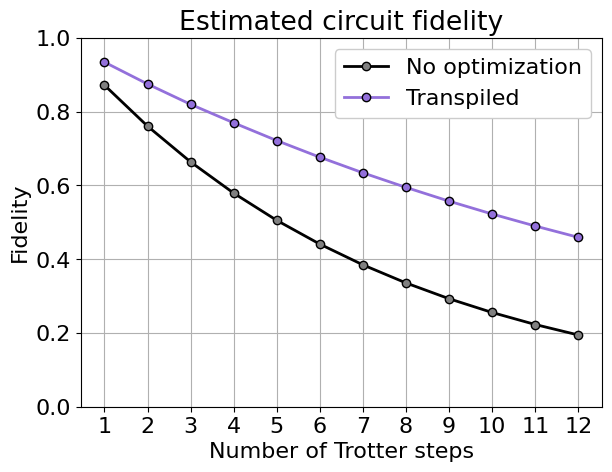

In [25]:
# Plot estimated circuit fidelity vs number of trotter steps
plt.plot(
    trotter_steps_array,
    qc_d_fid_ests,
    "k-o",
    label="No optimization",
    linewidth=2,
    markerfacecolor="gray",
)
plt.plot(
    trotter_steps_array,
    qc_t_fid_ests,
    "-o",
    label="Transpiled",
    linewidth=2,
    color="mediumpurple",
    markeredgecolor="k",
)
plt.xlabel("Number of Trotter steps")
plt.ylabel("Fidelity")
plt.ylim([0, 1])
plt.xticks(trotter_steps_array)
plt.legend(framealpha=1)
plt.grid()
plt.tight_layout()
plt.title("Estimated circuit fidelity")
plt.show()

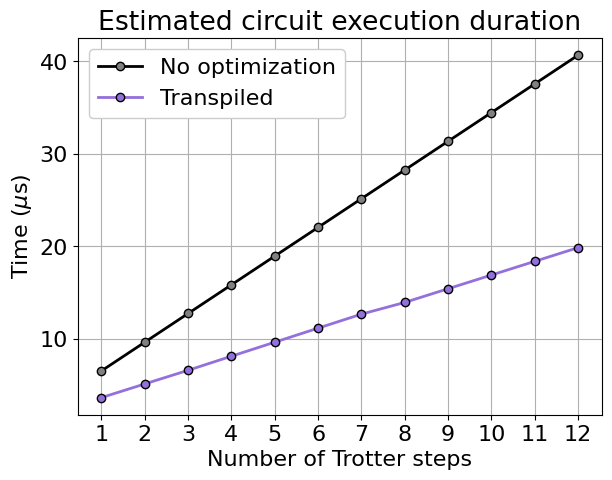

In [26]:
# Plot circuit runtime vs number of trotter steps
# Convert duractions to microseconds for plot
qc_d_dur_ests_us = np.array(qc_d_dur_ests) * 1e6
qc_t_dur_ests_us = np.array(qc_t_dur_ests) * 1e6

plt.plot(
    trotter_steps_array,
    qc_d_dur_ests_us,
    "k-o",
    linewidth=2,
    label="No optimization",
    markerfacecolor="gray",
)
plt.plot(
    trotter_steps_array,
    qc_t_dur_ests_us,
    "-o",
    color="mediumpurple",
    linewidth=2,
    label="Transpiled",
    markeredgecolor="k",
)
plt.xlabel("Number of Trotter steps")
plt.ylabel(r"Time ($\mu$s)")
# plt.ylim([0, 20e4])
plt.xticks(trotter_steps_array)
plt.legend(framealpha=1)
plt.grid()
plt.tight_layout()
plt.title("Estimated circuit execution duration")
plt.show()

### Only mitigating by transpilation
Just using the transpiler can dramatically improve quantum circuits (as seen in the plots above), but it's not that only way, nor will it always be the most effective. It is ultimately a black box optimization. Diving more deeply into the hardware and considering more about what error mitigation might be most useful, we can get even better results. Let's demonstrate this by running the transpiled circuit on the ibm_lagos now and compare it to when we combine many error mitigation techniques.


In [27]:
# Number of trotter steps
trotter_steps = 8

# Generate Trotterized evolution circuit
qc = gen_trott_qc(H, time_param, trotter_steps)

# Blindly use the transpiler
qc = transpile(qc.decompose(), basis_gates=basis_gates, optimization_level=3)

# Evaluate parameterized circuit over the range of time values used in the previous cells
qcs_8_ts = []
# Bind parameters for each step in time series
for time in tqdm(times):
    # Confirm all gates are optimized a 2nd time after binding parameters
    qc_eval = transpile(
        qc.bind_parameters({time_param: time}),
        basis_gates=basis_gates,
        optimization_level=3,
    )
    qcs_8_ts.append(qc_eval)

  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:00<00:10,  4.81it/s]

  4%|▍         | 2/50 [00:00<00:18,  2.65it/s]

  6%|▌         | 3/50 [00:01<00:20,  2.33it/s]

  8%|▊         | 4/50 [00:01<00:20,  2.21it/s]

 10%|█         | 5/50 [00:02<00:20,  2.15it/s]

 12%|█▏        | 6/50 [00:02<00:20,  2.11it/s]

 14%|█▍        | 7/50 [00:03<00:20,  2.09it/s]

 16%|█▌        | 8/50 [00:03<00:22,  1.89it/s]

 18%|█▊        | 9/50 [00:04<00:21,  1.93it/s]

 20%|██        | 10/50 [00:04<00:20,  1.97it/s]

 22%|██▏       | 11/50 [00:05<00:19,  1.98it/s]

 24%|██▍       | 12/50 [00:05<00:18,  2.00it/s]

 26%|██▌       | 13/50 [00:06<00:18,  2.01it/s]

 28%|██▊       | 14/50 [00:06<00:17,  2.02it/s]

 30%|███       | 15/50 [00:07<00:17,  2.03it/s]

 32%|███▏      | 16/50 [00:07<00:16,  2.02it/s]

 34%|███▍      | 17/50 [00:08<00:16,  2.03it/s]

 36%|███▌      | 18/50 [00:08<00:15,  2.03it/s]

 38%|███▊      | 19/50 [00:09<00:15,  2.04it/s]

 40%|████      | 20/50 [00:09<00:16,  1.87it/s]

 42%|████▏     | 21/50 [00:10<00:15,  1.92it/s]

 44%|████▍     | 22/50 [00:10<00:14,  1.95it/s]

 46%|████▌     | 23/50 [00:11<00:13,  1.98it/s]

 48%|████▊     | 24/50 [00:11<00:13,  1.99it/s]

 50%|█████     | 25/50 [00:12<00:12,  2.01it/s]

 52%|█████▏    | 26/50 [00:12<00:11,  2.02it/s]

 54%|█████▍    | 27/50 [00:13<00:11,  2.04it/s]

 56%|█████▌    | 28/50 [00:13<00:10,  2.05it/s]

 58%|█████▊    | 29/50 [00:14<00:10,  2.05it/s]

 60%|██████    | 30/50 [00:14<00:09,  2.03it/s]

 62%|██████▏   | 31/50 [00:15<00:09,  2.00it/s]

 64%|██████▍   | 32/50 [00:15<00:09,  1.97it/s]

 66%|██████▌   | 33/50 [00:16<00:09,  1.83it/s]

 68%|██████▊   | 34/50 [00:16<00:08,  1.90it/s]

 70%|███████   | 35/50 [00:17<00:07,  1.94it/s]

 72%|███████▏  | 36/50 [00:17<00:07,  1.98it/s]

 74%|███████▍  | 37/50 [00:18<00:06,  2.00it/s]

 76%|███████▌  | 38/50 [00:18<00:05,  2.02it/s]

 78%|███████▊  | 39/50 [00:19<00:05,  2.03it/s]

 80%|████████  | 40/50 [00:19<00:04,  2.04it/s]

 82%|████████▏ | 41/50 [00:20<00:04,  2.04it/s]

 84%|████████▍ | 42/50 [00:20<00:03,  2.05it/s]

 86%|████████▌ | 43/50 [00:21<00:03,  2.06it/s]

 88%|████████▊ | 44/50 [00:21<00:02,  2.07it/s]

 90%|█████████ | 45/50 [00:22<00:02,  2.07it/s]

 92%|█████████▏| 46/50 [00:22<00:01,  2.07it/s]

 94%|█████████▍| 47/50 [00:23<00:01,  1.88it/s]

 96%|█████████▌| 48/50 [00:23<00:01,  1.93it/s]

 98%|█████████▊| 49/50 [00:24<00:00,  1.96it/s]

100%|██████████| 50/50 [00:24<00:00,  1.99it/s]

100%|██████████| 50/50 [00:24<00:00,  2.02it/s]

In [28]:
shots = 10000
# backend = sim
# backend = sim_noisy_lagos
# backend = lagos

# Execute list of quantum circuits
job_8_ts_sim = execute_qcs(qcs_8_ts, backend, shots=shots)

Job ID 5538f8de-c66c-434d-b227-64eb41dae15f
Job Status: job is actively running

Job Status: job has successfully run


In [29]:
# Access old job if needed.
# jod_8_steps = '62e9204337e42fc816aed24d'
# jod_8_steps = '63286d880cfeefc4de7dc48f'
# jod_8_steps = '632bb5e1fcf0f30db3eacb6f'
# job_old = lagos.retrieve_job(jod_8_steps)

In [30]:
result = job_8_ts_sim.result()
counts = result.get_counts()

In [31]:
# Convert counts to expectation value of the number operator at each site
num_op_matrix_tran_8_ts = np.zeros((len(times), 5))
for i in range(len(times)):
    # Choose to use unmitigated counts here
    num_op_matrix_tran_8_ts[i, :] = dict_to_num_op_ex_val(counts[i], False, False)

**Note that the data shown below are from the simulator FakeLagos(), and are not as noisy as a real backend. See the paper for plots of data from the real backend ibm_lagos, or rerun the notebook using the real backend.**

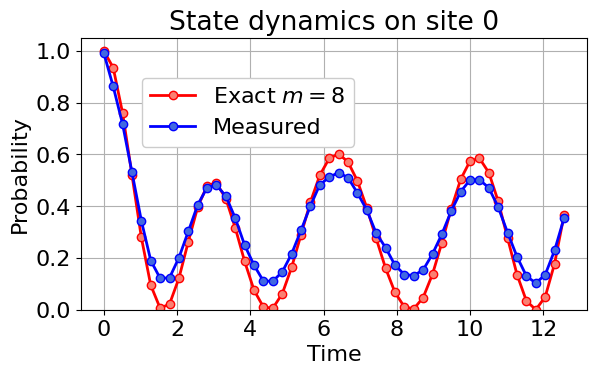

In [32]:
# Plot state dynamics of a particular site
site = 0

plt.figure(figsize=(6.25, 3.75))
plt.plot(
    times,
    evo_matrix_trot_8[:, site],
    "r-o",
    linewidth=2,
    label=r"Exact $m=8$",
    markerfacecolor="salmon",
    zorder=2,
)
plt.plot(
    times,
    num_op_matrix_tran_8_ts[:, site],
    "b-o",
    linewidth=2,
    label=r"Measured",
    markerfacecolor="royalblue",
)
plt.xlabel("Time")
plt.ylabel("Probability")
plt.ylim([0.0, 1.05])
plt.grid()
plt.legend(loc=(0.12, 0.6), framealpha=1)
plt.tight_layout()
plt.title("State dynamics on site " + str(site))
plt.show()

The dynamics are almost immediately washed out when using the real backend (see paper) even though we use the transpiler to optimize the circuit. Can we do better? Yes! Let's explore more mitigation techniques and strategies.

## Mitigated Simulation

### Map-o-matic
We can find additional improvements by picking qubits with the best coherence times and lowest gate errors. The [map-o-matic](https://github.com/Qiskit-Partners/mapomatic) tool does just that. In our case, we are using a 7-qubit device, but are only computing on 5 of them. Which 5 qubits do we choose? Based on the couplings of the system we want to simulate, having 5 qubits connected in a line would be the best option. Other configurations would require SWAP gates which come at the expense of 3 CNOT gates each.

There are four unique combinations where five of the seven qubits are in a line. Map-o-matic will calculate which is the best for us. We will store this list of qubits in the list `q_regs` for later use.

In [33]:
import mapomatic as mm

small_qc = mm.deflate_circuit(transpile(qcs[1], backend=backend, optimization_level=0))
score = mm.best_overall_layout(small_qc, backend)
# Extract the quantum registers from score list
q_regs = score[0]
print("map-o-matic (quantum registers, backend, score):", score)

map-o-matic (quantum registers, backend, score): ([6, 5, 3, 1, 2], 'fake_lagos', 0.1388134054197604)


### Measurement Error Mitigation

We directly follow the [mthree tutorial](https://qiskit.org/documentation/partners/mthree/basic.html) for scalable measurement error mitigation. For further examples, see the [Qiskit textbook's](https://qiskit.org/textbook/preface.html) tutorial on [measurement error mitigation](https://qiskit.org/textbook/ch-quantum-hardware/measurement-error-mitigation.html#version-information). Below, we first demonstrate this technique on a simple example of a GHZ state $\left(|00000\rangle + |11111\rangle \right)/ \sqrt{2}$. We will use it for the quantum simulation at the very end.

In [34]:
import mthree

# This submits jobs to the queue when using real backends
mit = mthree.M3Mitigation(backend)
mit.cals_from_system(q_regs)

The M3 mitigator is now ready to go. We'll now apply it to preparing a GHZ state over 5 qubits.

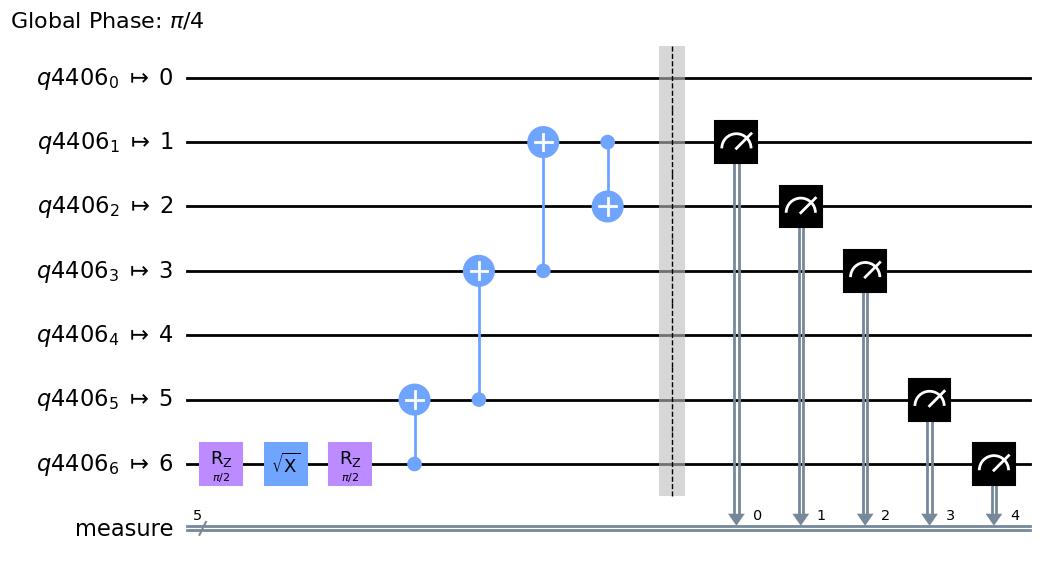

In [35]:
# Initialize quantum circuit
qrs = QuantumRegister(7)  # working with lagos
qc = QuantumCircuit(qrs)

# Generate the GHZ state: (|00000> + \11111>) / Sqrt[2]
qc.h(q_regs[0])
qc.cx(q_regs[0], q_regs[1])
qc.cx(q_regs[1], q_regs[2])
qc.cx(q_regs[2], q_regs[3])
qc.cx(q_regs[3], q_regs[4])

qc.measure_active()

qc = transpile(qc, basis_gates=basis_gates, backend=backend)
qc.draw("mpl")

In [36]:
shots = 10000
# backend = sim
# backend = sim_noisy_lagos
# backend = lagos

# Execute list of quantum circuits
job = execute_qcs(qc, backend, shots=shots)

Job ID 0c649b07-cde7-4f72-b638-49d523711251
Job Status: job is being initialized

Job Status: job has successfully run


In [37]:
# Get qc results and counts
results = job.result()
noisy_counts = results.get_counts()

**Note that the data shown below are from the simulator FakeLagos(), and are not as noisy as a real backend. See the paper for plots of data from the real backend ibm_lagos, or rerun the notebook using the real backend.**

Expected 50% +/- 0.5 % of |00000> and |11111>


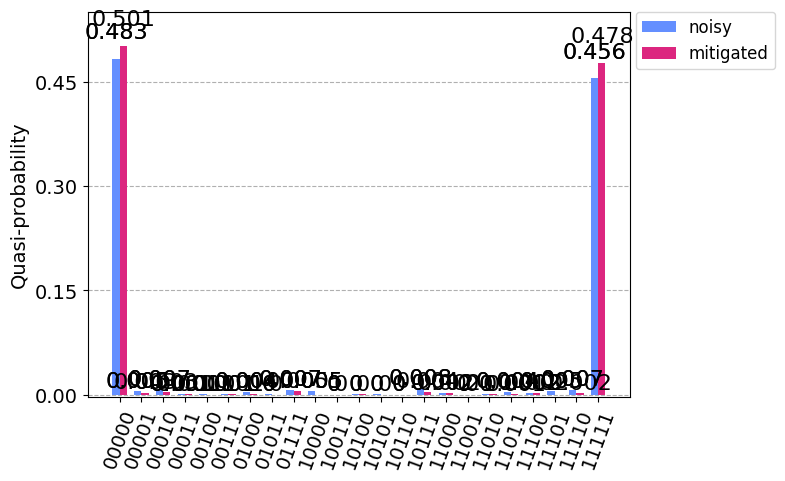

In [38]:
from qiskit.visualization import plot_histogram

# Get qc results and counts
results = job.result()
noisy_counts = results.get_counts()

# Apply measurement error mitigation post-processing
mitigated_probs = mit.apply_correction(noisy_counts, q_regs)

# Calculation probabilities between no measurement error mitigation and some
noisy_p0s = noisy_counts["00000"] / shots
noisy_p1s = noisy_counts["11111"] / shots
mit_p0s = mitigated_probs["00000"]
mit_p1s = mitigated_probs["11111"]
print("Expected 50% +/-", np.sqrt(0.5 * 0.5 / shots) * 100, "% of |00000> and |11111>")

# Compare before and after measurement error mitigation
plot_histogram([noisy_counts, mitigated_probs], legend=["noisy", "mitigated"])

### $R_{ZX}(\theta)$ Gate Optimization
Two-qubit gate errors are the main source of error for current (NISQ era) quantum computers. One way to get a significant reduction in two-qubit errors is to dive closer to the physics of the underlying qubits and use the native two-qubit gates instead of CNOT gates. Read the [paper](https://arxiv.org/abs/2209.02795) and references therein for more details. In short, we want to compose all two-qubit gates in terms of [$R_{ZX}(\theta)$ gate operations](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RZXGate.html).

Compose the circuit in terms of $R_{ZX}(\theta)$ gate operations instead of CNOT gates.

In [39]:
from qiskit.converters import circuit_to_dag, dag_to_circuit


def estimate_fidelity(circuit, initial_layout, backend):
    """
    New function to estimate of circuit fidelity to account for RZX gates and how they are scaled (theta value relative to pi/2).

    Assume linear dependence between gate error and RZX angle.

    Args:
        circuit - QuantumCircuit; the quantum circuit you want to compute the gate error for.
        initial_layout - list of ints; quantum register of which qubit are being used in the circuit.
        backend - IBMQBackend; the specific device the circuit will be executed on.

    Returns:
        fidelity - float;  estimated fidelity of circuit with Rzx gate operations
    """

    dag = circuit_to_dag(circuit)
    rzx_runs = dag.collect_runs(["rzx"])
    try:
        num_cx = circuit.count_ops()["cx"]
    except KeyError:
        num_cx = 0

    # Compute average 2-qubit gate error over the qubits in use
    avg_gate_error = 0
    for ii in range(len(initial_layout) - 1):
        q0 = initial_layout[ii]
        q1 = initial_layout[ii + 1]
        avg_gate_error += backend.properties().gate_property("cx")[(q0, q1)][
            "gate_error"
        ][0]
    avg_gate_error /= len(initial_layout) - 1

    # Get Rzx error
    est_fid_rzx = 1
    for rzx_run in rzx_runs:
        angle = rzx_run[0].op.params[0]
        this_rzx_error = (abs(float(angle)) / (np.pi / 2)) * avg_gate_error
        est_fid_rzx *= 1 - this_rzx_error

    est_fid_rzx *= (1 - avg_gate_error) ** num_cx

    # Compute average single qubit gate errors
    ops = circuit.count_ops()  # get the number of each type of gate in the circuit
    est_fid_1q = compute_circuit_gate_fidelity(
        0, ops["sx"] + ops["x"], 1, 1 - avg_sx_err
    )

    return est_fid_1q * est_fid_rzx


def total_rzx_angle(circuit):
    """
    Add up the total evolution time (thetas) of the Rzx gates in a given circuit.

    Useful for quanitfying error and debugging circuits.

    Args:
        circuit - QuantumCircuit; the quantum circuit you wish to analyze

    Returns:
        total_rzx_angle - float; total amount of angle evolved by all the R_zx gate operations of the circuit
    """
    dag = circuit_to_dag(circuit)
    rzx_runs = dag.collect_runs(["rzx"])
    try:
        num_cx = circuit.count_ops()["cx"]
    except KeyError:
        num_cx = 0

    # Sum up the absolute value of all the rzx angles
    total_rzx_angle = 0

    # Get Rzx error
    est_fid_rzx = 1
    for rzx_run in rzx_runs:
        angle = rzx_run[0].op.params[0]
        total_rzx_angle += abs(angle)

    return total_rzx_angle

In [40]:
# Transpiler passes needed to efficiently convert circuit to RZX gates
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import (
    TemplateOptimization,
    Collect2qBlocks,
    ConsolidateBlocks,
    EchoRZXWeylDecomposition,
    Optimize1qGatesDecomposition,
    RZXCalibrationBuilderNoEcho,
)

# PassManager used on circuit with Parameterized time values
# It combines gates into blocks that act of 2 qubits then decomposes those 2-qubit blocks
# in terms of Rzx gates using the KAK decomposition
# Also optimizes single qubit gates.
pm_rzx_param = PassManager(
    [
        Collect2qBlocks(),
        ConsolidateBlocks(basis_gates=basis_gates + ["rzx"]),
        # Rewrite circuit in terms of Weyl-decomposed echoed RZX gates.
        EchoRZXWeylDecomposition(defaults.instruction_schedule_map),
        # Reduce the number of single qubit gates
        Optimize1qGatesDecomposition(basis_gates),
    ]
)

# Alternative method using the RZX template optimization
# # Make the RZX transpiler pass using template optimization
# pm_rzx_template = PassManager([
#     # Identify where an RZX gate could replace two CNOTs sandwiching an Rz
#     TemplateOptimization(**rzx_templates.rzx_templates()),
#     # Clean up single qubit gates
#     Optimize1qGatesDecomposition(basis_gates + ['rzx'])
# ])

In [41]:
# Number of trotter steps
trotter_steps = 1

# Generate Trotterized evolution circuit
qc = gen_trott_qc(H, time_param, trotter_steps)

# Convert CNOTs to RZX gates
qc_rzx = pm_rzx_param.run(qc)

Circuit operations: OrderedDict([('rz', 90), ('sx', 46), ('rzx', 32), ('x', 24), ('measure', 5)])


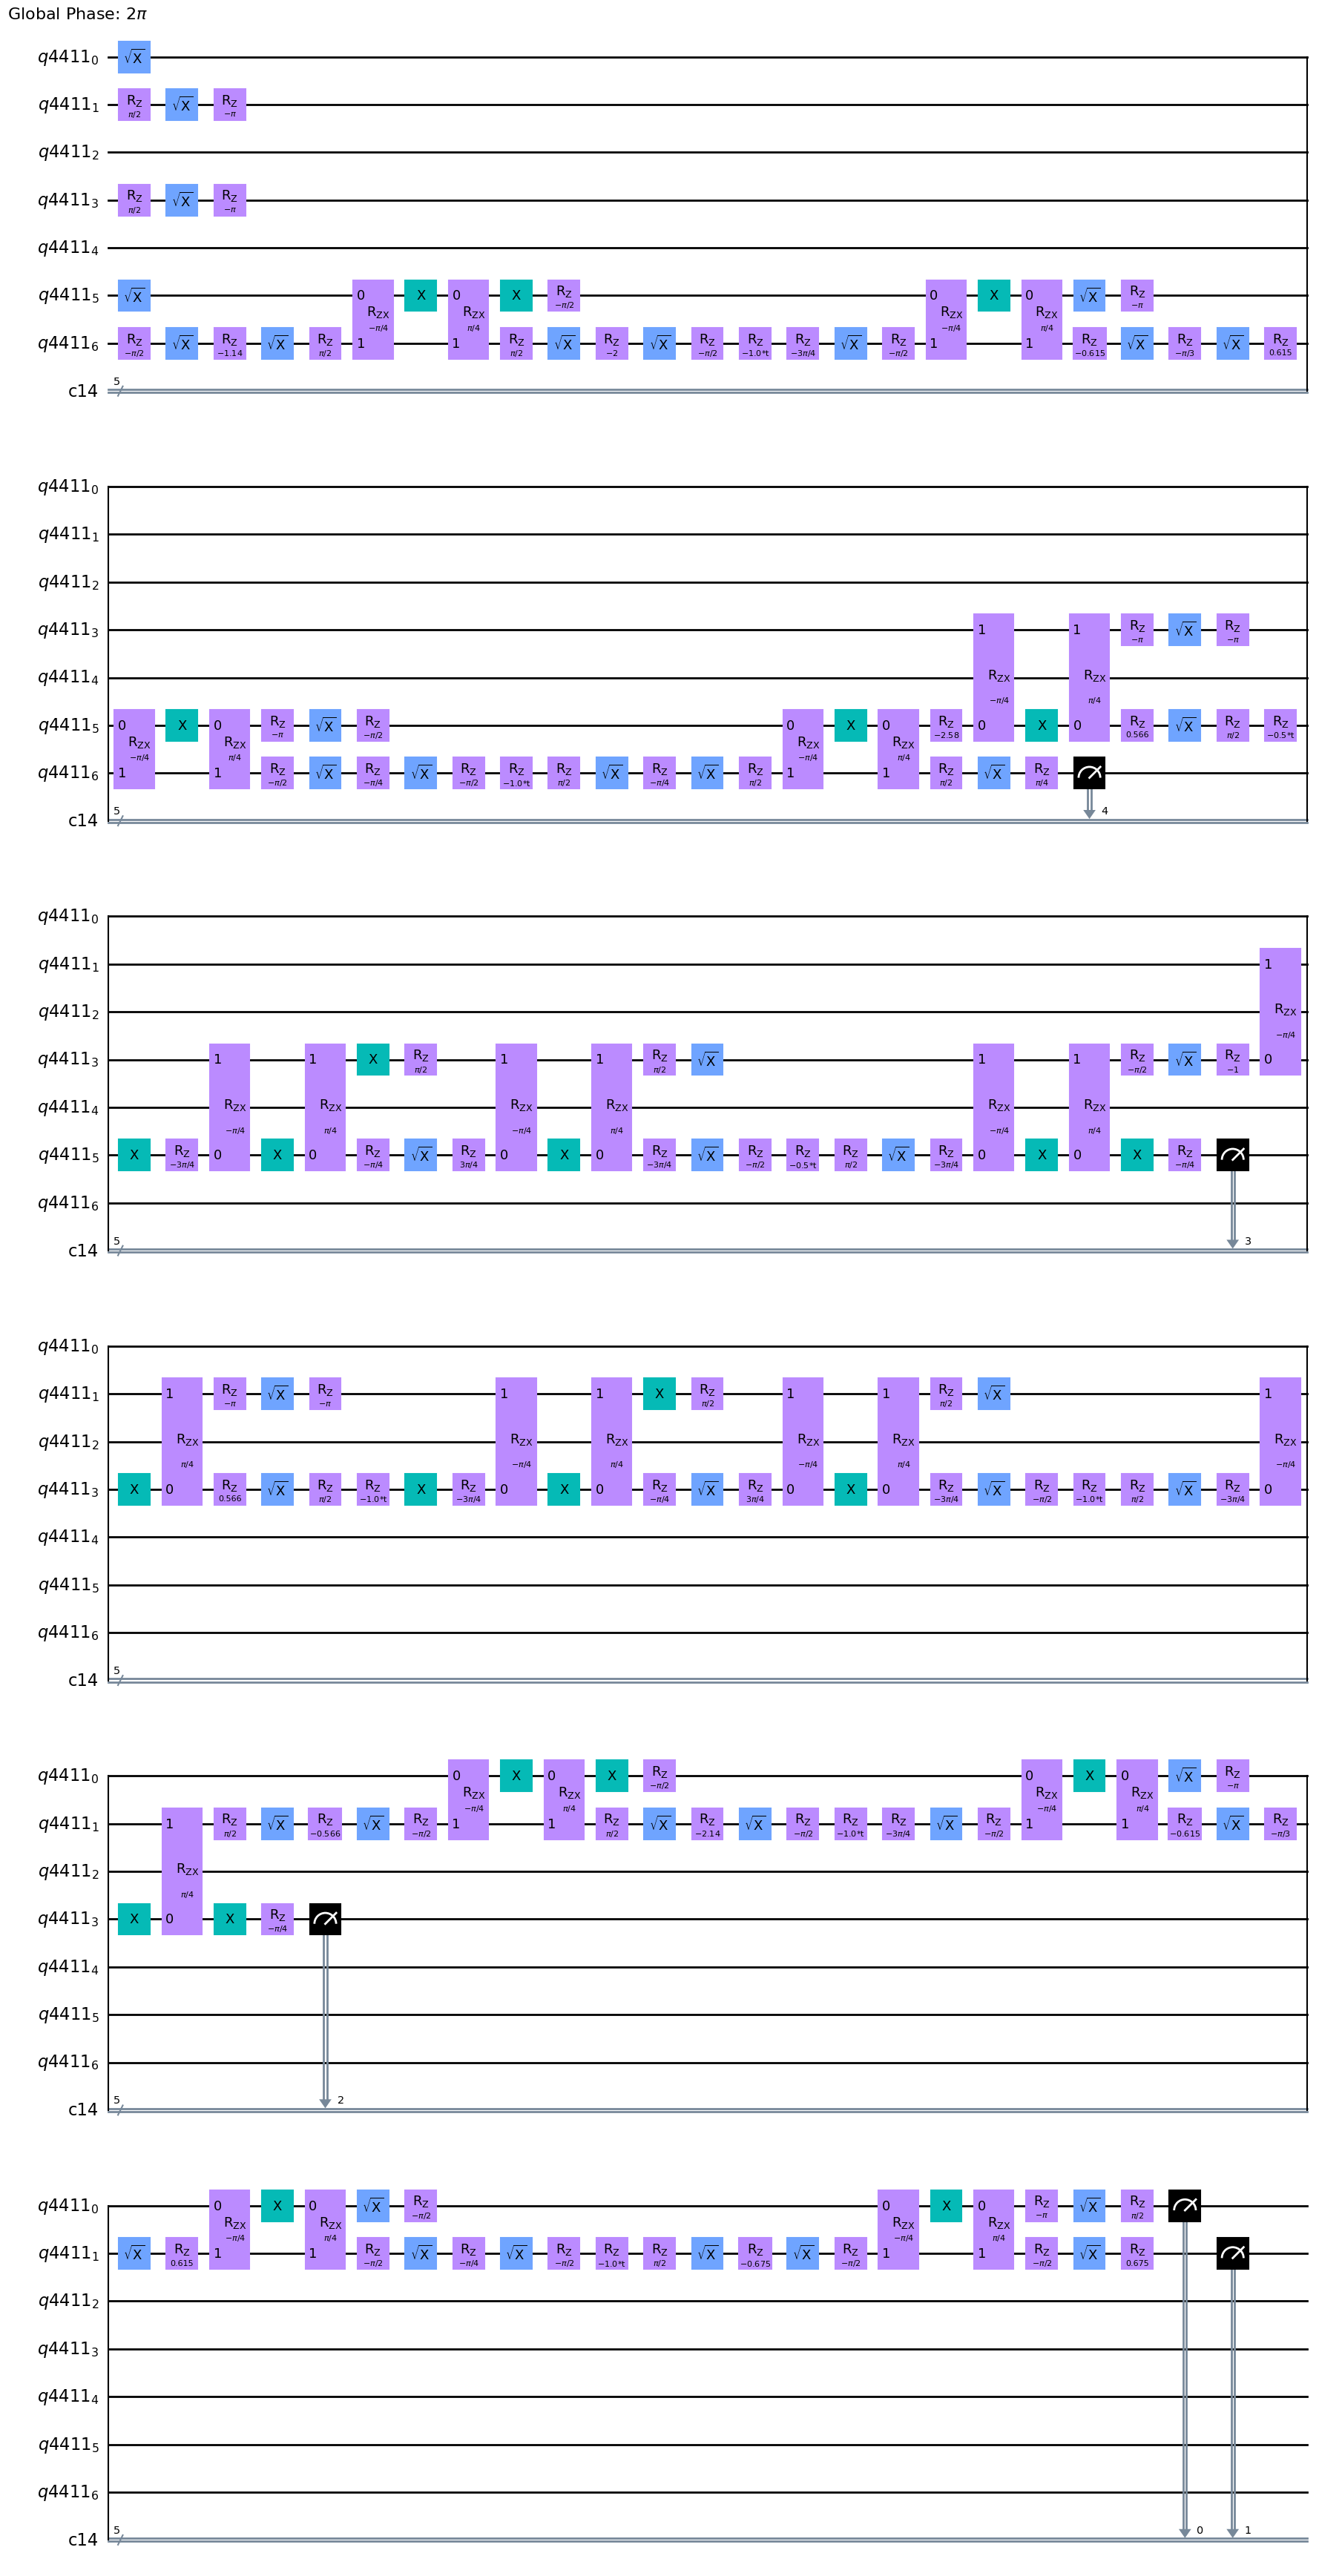

In [42]:
print("Circuit operations:", qc_rzx.count_ops())
qc_rzx.draw("mpl")

Notice how the $R_{ZX}$ gates all have the same angle $\pi/4$ and that it's some of the $R_Z$ gates that have the parameter $t$ in their arguments. This is not what we want. We want the angle of the $R_{ZX}$ gates to change as a function of time, not the $R_Z$ gates. We will need to evaluate the circuits $t$ Parameter first to get this behavior.

In [43]:
# Apply transpiler passes that gives Rzx gates a scaled pulse schedule and optimized single qubit gates
inst_sched_map = defaults.instruction_schedule_map
channel_map = config.qubit_channel_mapping
pm_rzx_cal = PassManager(
    [
        Collect2qBlocks(),
        ConsolidateBlocks(basis_gates=basis_gates + ["rzx"]),
        EchoRZXWeylDecomposition(defaults.instruction_schedule_map),
        # Scale Rzx gates to the desired angle
        RZXCalibrationBuilderNoEcho(inst_sched_map, channel_map),
        Optimize1qGatesDecomposition(basis_gates + ["rzx"]),
    ]
)

# Number of trotter steps
trotter_steps = 8

# Generate Trotterized evolution circuit
qc = gen_trott_qc(H, time_param, trotter_steps)

# Empty list to store quantum circuits for each time point
qcs_rzx = []
# Empty list fto store the fidelity of each circuit
rzx_fids = []
# Bind parameters for each step in time series THEN conver to RZX gates and add RZX schedule making each RZX gate a "pulsed gated"
for time in tqdm(times):

    qc_t = qc.bind_parameters({time_param: time})

    # Apply transpiler passes that gives Rzx gates a pulse schedule and optimized single qubit gates
    qc_t = pm_rzx_cal.run(qc_t)

    qcs_rzx.append(qc_t)
    rzx_fids.append(estimate_fidelity(qc_t, q_regs, backend))

  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:00<00:16,  3.00it/s]

  4%|▍         | 2/50 [00:00<00:23,  2.02it/s]

  6%|▌         | 3/50 [00:01<00:24,  1.90it/s]

  8%|▊         | 4/50 [00:02<00:29,  1.58it/s]

 10%|█         | 5/50 [00:02<00:27,  1.65it/s]

 12%|█▏        | 6/50 [00:03<00:26,  1.69it/s]

 14%|█▍        | 7/50 [00:04<00:25,  1.70it/s]

 16%|█▌        | 8/50 [00:04<00:24,  1.71it/s]

 18%|█▊        | 9/50 [00:05<00:24,  1.71it/s]

 20%|██        | 10/50 [00:05<00:23,  1.73it/s]

 22%|██▏       | 11/50 [00:06<00:22,  1.75it/s]

 24%|██▍       | 12/50 [00:06<00:21,  1.74it/s]

 26%|██▌       | 13/50 [00:07<00:21,  1.73it/s]

 28%|██▊       | 14/50 [00:08<00:20,  1.73it/s]

 30%|███       | 15/50 [00:08<00:20,  1.74it/s]

 32%|███▏      | 16/50 [00:09<00:19,  1.70it/s]

 34%|███▍      | 17/50 [00:09<00:19,  1.70it/s]

 36%|███▌      | 18/50 [00:10<00:21,  1.50it/s]

 38%|███▊      | 19/50 [00:11<00:19,  1.55it/s]

 40%|████      | 20/50 [00:11<00:18,  1.60it/s]

 42%|████▏     | 21/50 [00:12<00:17,  1.63it/s]

 44%|████▍     | 22/50 [00:12<00:16,  1.66it/s]

 46%|████▌     | 23/50 [00:13<00:16,  1.66it/s]

 48%|████▊     | 24/50 [00:14<00:15,  1.67it/s]

 50%|█████     | 25/50 [00:14<00:14,  1.69it/s]

 52%|█████▏    | 26/50 [00:15<00:14,  1.68it/s]

 54%|█████▍    | 27/50 [00:15<00:13,  1.68it/s]

 56%|█████▌    | 28/50 [00:16<00:13,  1.63it/s]

 58%|█████▊    | 29/50 [00:17<00:12,  1.64it/s]

 60%|██████    | 30/50 [00:17<00:12,  1.64it/s]

 62%|██████▏   | 31/50 [00:18<00:11,  1.63it/s]

 64%|██████▍   | 32/50 [00:19<00:12,  1.44it/s]

 66%|██████▌   | 33/50 [00:19<00:11,  1.49it/s]

 68%|██████▊   | 34/50 [00:20<00:10,  1.51it/s]

 70%|███████   | 35/50 [00:21<00:09,  1.52it/s]

 72%|███████▏  | 36/50 [00:21<00:09,  1.54it/s]

 74%|███████▍  | 37/50 [00:22<00:08,  1.55it/s]

 76%|███████▌  | 38/50 [00:23<00:07,  1.55it/s]

 78%|███████▊  | 39/50 [00:23<00:07,  1.55it/s]

 80%|████████  | 40/50 [00:24<00:06,  1.54it/s]

 82%|████████▏ | 41/50 [00:25<00:05,  1.53it/s]

 84%|████████▍ | 42/50 [00:25<00:05,  1.50it/s]

 86%|████████▌ | 43/50 [00:26<00:04,  1.50it/s]

 88%|████████▊ | 44/50 [00:27<00:04,  1.50it/s]

 90%|█████████ | 45/50 [00:27<00:03,  1.49it/s]

 92%|█████████▏| 46/50 [00:28<00:03,  1.31it/s]

 94%|█████████▍| 47/50 [00:29<00:02,  1.36it/s]

 96%|█████████▌| 48/50 [00:30<00:01,  1.39it/s]

 98%|█████████▊| 49/50 [00:30<00:00,  1.41it/s]

100%|██████████| 50/50 [00:31<00:00,  1.43it/s]

100%|██████████| 50/50 [00:31<00:00,  1.59it/s]

In [44]:
# qcs_rzx[-2].draw('mpl')

In [45]:
# Circuit fidelity comparison
# the 0th index is the circuit with 1 trotter step
print(f"Circuit fidelity: {qc_d_fid_ests[trotter_steps - 1]:.4f}")
# the 0th index is the circuit with 1 trotter step
print(f"Transpiled circuit fidelity: {qc_t_fid_ests[trotter_steps - 1]:.4f}")
print(f"RZX circuit fidelity: {np.mean(rzx_fids):.4f}")

Circuit fidelity: 0.3357
Transpiled circuit fidelity: 0.5948
RZX circuit fidelity: 0.8028


### Estimate circuit error and circuit duration vs number of trotter steps (RZX optimization)
Let's expand this analysis to a range of trotter steps. The $R_{ZX}$ optimized circuits will have a varying fidelity for different time points because different time points share a different amount of $R_{ZX}$ evolution. We will average over those effects.

In [46]:
# Evaulate all circuits over all time points and take the mean

# Compute parameterized circuit over a range of trotter steps
trotter_steps_array = np.arange(1, 13)

# Empty list to store estimate of quantum circuit fidelity
qc_rzx_fid_ests = []
# Empty list to store estimate of quantum duration
qc_rzx_dur_ests = []
# Empty list to store final quantum circuits
qcs_rzx_trotter_steps = []
for trotter_steps in tqdm(trotter_steps_array):
    # Generate Trotterized evolution circuit
    qc = gen_trott_qc(H, time_param, trotter_steps)

    # Bind time value and Hamiltonian parameters
    # Empty list to store circuit fidelities over the range of time points (later averaged over)
    rzx_fids = []
    # Empty list to store circuit durations over the range of time points (later averaged over)
    qc_dur = []
    rzx_angles = []
    for time in times:

        qc_t = qc.bind_parameters({time_param: time})

        # Apply transpiler passes that gives Rzx gates a pulse schedule and optimized single qubit gates
        qc_t = pm_rzx_cal.run(qc_t)

        # Store circuit, fidelity estimate, and duration estimate
        qcs_rzx_trotter_steps.append(qc_t)
        rzx_fids.append(estimate_fidelity(qc_t, q_regs, backend))
        qc_dur.append(schedule(qc_t, backend).duration * config.dt)
        rzx_angles.append(total_rzx_angle(qc_t))

    # Calculate average fidelity for a given trotter step
    qc_rzx_fid_ests.append(np.mean(rzx_fids))

    # Calculate average duration for a given trotter step
    qc_rzx_dur_ests.append(np.mean(qc_dur))

  0%|          | 0/12 [00:00<?, ?it/s]

  8%|▊         | 1/12 [00:10<01:57, 10.64s/it]

 17%|█▋        | 2/12 [00:29<02:32, 15.22s/it]

 25%|██▌       | 3/12 [00:55<03:03, 20.37s/it]

 33%|███▎      | 4/12 [01:28<03:22, 25.36s/it]

 42%|████▏     | 5/12 [02:09<03:36, 30.92s/it]

 50%|█████     | 6/12 [02:57<03:40, 36.77s/it]

 58%|█████▊    | 7/12 [03:52<03:33, 42.69s/it]

 67%|██████▋   | 8/12 [04:54<03:15, 48.90s/it]

 75%|███████▌  | 9/12 [06:02<02:44, 54.88s/it]

 83%|████████▎ | 10/12 [07:17<02:02, 61.15s/it]

 92%|█████████▏| 11/12 [08:38<01:07, 67.12s/it]

100%|██████████| 12/12 [10:06<00:00, 73.61s/it]

100%|██████████| 12/12 [10:06<00:00, 50.57s/it]

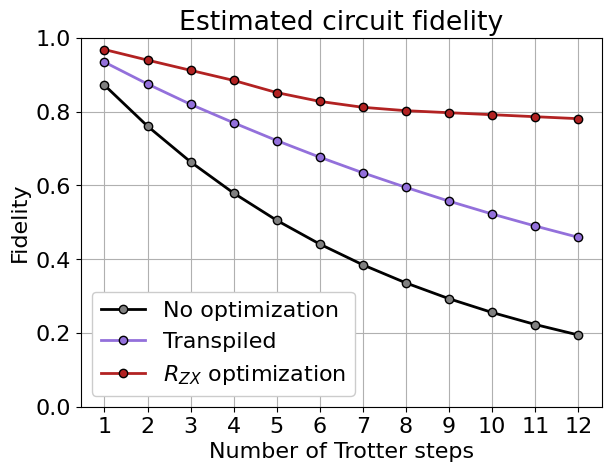

One trotter step fidelities no opt: 0.8721 transpiled: 0.9346 rzx opt: 0.9687
Ten trotter step fidelities no opt: 0.2556 transpiled: 0.5226 rzx opt: 0.7920


In [47]:
# Plot
plt.plot(
    trotter_steps_array,
    qc_d_fid_ests,
    "k-o",
    label="No optimization",
    linewidth=2,
    markerfacecolor="gray",
)
plt.plot(
    trotter_steps_array,
    qc_t_fid_ests,
    "-o",
    label="Transpiled",
    linewidth=2,
    color="mediumpurple",
    markeredgecolor="k",
)
plt.plot(
    trotter_steps_array,
    qc_rzx_fid_ests,
    "-o",
    label=r"$R_{ZX}$ optimization",
    linewidth=2,
    color="firebrick",
    markeredgecolor="k",
)
plt.xlabel("Number of Trotter steps")
plt.ylabel("Fidelity")
plt.ylim([0, 1])
plt.xticks(trotter_steps_array)
plt.legend(framealpha=1)
plt.grid()
plt.tight_layout()
plt.title("Estimated circuit fidelity")
plt.show()

print(
    f"One trotter step fidelities",
    f"no opt: {qc_d_fid_ests[0]:.4f}",
    f"transpiled: {qc_t_fid_ests[0]:.4f}",
    f"rzx opt: {qc_rzx_fid_ests[0]:.4f}",
)
print(
    f"Ten trotter step fidelities",
    f"no opt: {qc_d_fid_ests[9]:.4f}",
    f"transpiled: {qc_t_fid_ests[9]:.4f}",
    f"rzx opt: {qc_rzx_fid_ests[9]:.4f}",
)

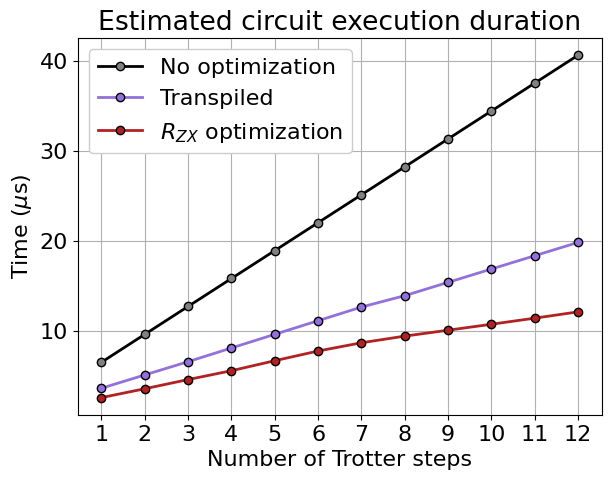

In [48]:
# Plot
plt.plot(
    trotter_steps_array,
    np.array(qc_d_dur_ests) * 1e6,
    "k-o",
    linewidth=2,
    label="No optimization",
    markerfacecolor="gray",
)
plt.plot(
    trotter_steps_array,
    np.array(qc_t_dur_ests) * 1e6,
    "-o",
    color="mediumpurple",
    linewidth=2,
    label="Transpiled",
    markeredgecolor="k",
)
plt.plot(
    trotter_steps_array,
    np.array(qc_rzx_dur_ests) * 1e6,
    "-o",
    color="firebrick",
    linewidth=2,
    label=r"$R_{ZX}$ optimization",
    markeredgecolor="k",
)
plt.xlabel("Number of Trotter steps")
plt.ylabel(r"Time ($\mu$s)")
# plt.ylim([0, 20e4])
plt.xticks(trotter_steps_array)
plt.legend(framealpha=1)
plt.grid()
plt.tight_layout()
plt.title("Estimated circuit execution duration")
plt.show()

## Execute Quantum Simulation with Combined Techniques
Bring map-o-matic, measurement error mitigation, $R_{ZX}$ gates, and particle conservation (more on that later) together and simulate the state dynamics! (This requires the upper sections to be executed.)

In [49]:
shots = 10000
# backend = sim
# backend = sim_noisy_lagos
# backend = lagos

# Execute list of quantum circuits
job_rzx = execute_qcs(qcs_rzx, backend, shots=shots)

Job ID

 4c6be94b-3984-4ab7-8adc-c2e5bd7ef092
Job Status: job is actively running

Job Status: job has successfully run


In [50]:
# Save previous job ids to get access later, if needed.
# job_id_8_steps = '62b1326c00686284a508a274'
# job_id_8_steps = '62e9c49b3e2c28cce3bd55cd'
# job_id_8_steps = '632ba7ca05c8fd41299006d0'

# job_old = lagos.retrieve_job(job_id_8_steps)

In [51]:
# Get count from quantum computer
results = job_rzx.result()
counts = results.get_counts()

# Apply measurement error mitigation post-processing
mit_probs = mit.apply_correction(counts, q_regs)

In [52]:
# Convert counts to expectation value of the number operator at each site
num_op_matrix_rzx_8_ts = np.zeros((len(times), 5))
for i in range(len(times)):
    # Choose to use mitigated counts or unmitigated counts in the argument below
    num_op_matrix_rzx_8_ts[i, :] = dict_to_num_op_ex_val(mit_probs[i], True, False)

**Note that the data shown below are from the simulator FakeLagos(), and are not as noisy as a real backend. See the paper for plots of data from the real backend ibm_lagos, or rerun the notebook using the real backend.**

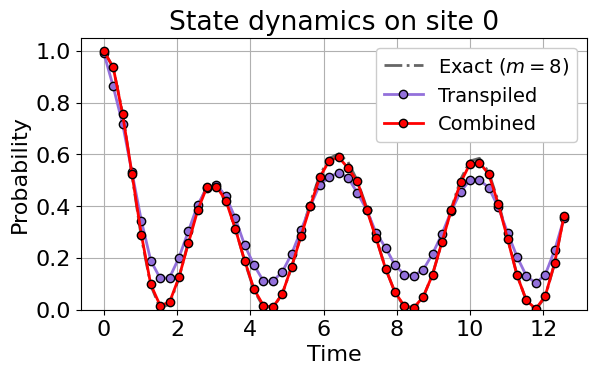

In [53]:
# Plot state dynamics of a particular site
site = 0

plt.figure(figsize=(6.25, 3.75))
plt.plot(
    times,
    evo_matrix_trot_8[:, site],
    "k-.",
    linewidth=2,
    label=r"Exact ($m=8$)",
    alpha=0.6,
)
plt.plot(
    times,
    num_op_matrix_tran_8_ts[:, site],
    "-o",
    color="mediumpurple",
    linewidth=2,
    label="Transpiled",
    markeredgecolor="k",
)
plt.plot(
    times,
    num_op_matrix_rzx_8_ts[:, site],
    "r-o",
    linewidth=2,
    label="Combined",
    markeredgecolor="k",
)
plt.xlabel("Time")
plt.ylabel("Probability")
plt.ylim([0.0, 1.05])
plt.grid()
plt.legend(framealpha=1, fontsize=14)
plt.tight_layout()
plt.title("State dynamics on site " + str(site))
plt.show()

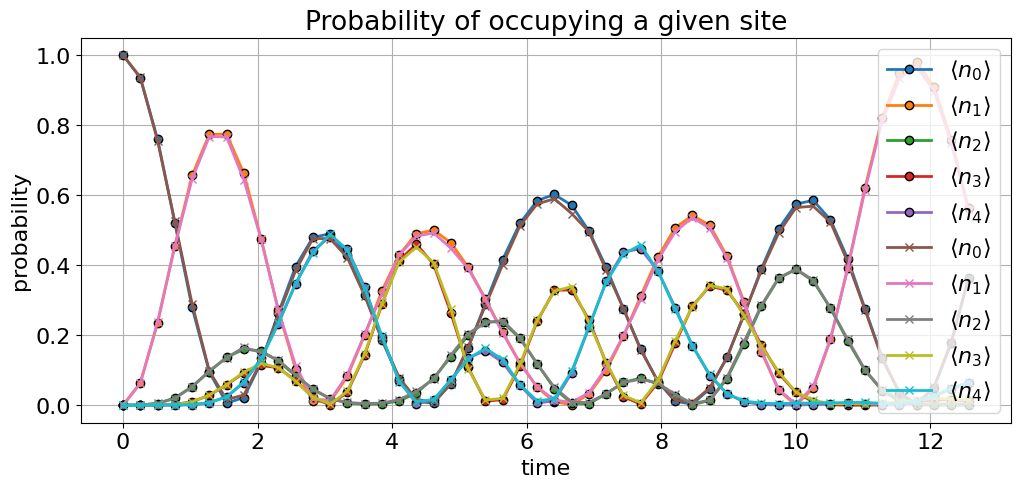

In [54]:
# Plot full time evolution in cross sections. Messy but eveything is there.

num_op_labels = [r"$\langle n_" + str(i) + "\\rangle$" for i in range(num_sites)]

plt.figure(figsize=(12, 5))
plt.plot(times, evo_matrix_trot, "-o", linewidth=2, markeredgecolor="k")
plt.plot(times, num_op_matrix_rzx_8_ts, "-x", linewidth=2)
plt.xlabel("time")
plt.ylabel("probability")
plt.title("Probability of occupying a given site")
plt.grid()
plt.legend(num_op_labels + num_op_labels)
plt.show()

In [55]:
import qiskit.tools.jupyter

%qiskit_version_table